In [947]:
from sklearn.metrics import root_mean_squared_error, accuracy_score, precision_recall_fscore_support
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.feature_selection import SelectKBest, chi2, RFE, mutual_info_regression
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from sklearn.svm import SVC, LinearSVC
from keras.utils import to_categorical
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import pandas as pd
import numpy as np
import joblib

# Feature Engineering

First, we will load the data into our DataFrame. Sort by date and denote which Season each match corresponds to. 

In [948]:
data_dir = "finalData.csv"
df = pd.read_csv(data_dir)

In [949]:
# renaming the columns
df.columns = ['Date', 'Home Team', 'Away Team', 'Full Time Home Goals', 'Full Time Away Goals', 'Full Time Result',       
'Half Time Home Goals', 'Half Time Away Goals', 'Half Time Result', 'Referee', 'Home Shots', 'Away Shots', 'Home Shots on Target',   
'Away Shots on Target', 'Home Corners', 'Away Corners', 'Home Fouls', 'Away Fouls', 'Home Yellow Cards', 'Away Yellow Cards',     
'Home Red Cards', 'Away Red Cards', 'Home Possession', 'Away Possession', 'Home Passes Completed', 'Home Passes PCT',
'Home Progressive Passes', 'Home Progressive Passing Distance', 'Home xG', 'Home Take Ons Won', 'Home Take Ons', 
'Home Interceptions', 'Home Blocks', 'Home Touches', 'Home Touches Def 3rd', 'Home Touches Mid 3rd', 'Home Touches Att 3rd',
'Home Carries', 'Home Carries Progressive Distance', 'Home Tackles', 'Home Tackles Won', 'Away Passes Completed',
'Away Passes PCT', 'Away Progressive Passes', 'Away Progressive Passing Distance', 'Away xG',
'Away Take Ons Won', 'Away Take Ons', 'Away Interceptions', 'Away Blocks', 'Away Touches', 'Away Touches Def 3rd',
'Away Touches Mid 3rd', 'Away Touches Att 3rd', 'Away Carries', 'Away Carries Progressive Distance', 'Away Tackles',
'Away Tackles Won']

In [950]:
# ensure sorted by date
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df = df.sort_values(by='Date')

# each season starts at 08 and ends at 05 of next year - 2000-2001 season will be the 2000 season
def get_season(date):
    if date.month >= 8:  
        return (date.year)
    else:  
        return (date.year - 1)

df['Season'] = df['Date'].apply(get_season)
df['Match Outcome'] = df['Full Time Result'].map({'H': 1, 'D': 0, 'A': -1})

Here, we begin engineering new features. The following function enables us to find the previous matches a team played (within this or the previous season). Using this key function, we created several features:

Average Goal Conversion Rate Difference, Average Attacking Intensity Difference, Average Disciplinary Pressure Difference, Recent Performances, Average Goals Scored Difference, Average Goals Conceded Difference, ...

Note: All averages use the previous RECENCY_NUM matches. If the number of previous matches in this season is too few, it will draw from the previous season as well. 

Note 2: After feature engineering, we will have to remove 101 matches that do not have RECENCY_NUM=5 matches prior. Unfortunately, this will reduce our dataset by 3.66%.

In [951]:
RECENCY_NUM = 5

In [952]:
# Team Points = total points in the game. win:3, draw:1, loss:0... DROPPED AFTERWARDS
# Total Points = cumulative sum of the team points, per team, per season
# Point Difference = difference between total points of the teams, per match
def calculate_season_points(df):
    df['Home Team Points'] = 0
    df['Away Team Points'] = 0

    for idx, row in df.iterrows():
        if row['Match Outcome'] == 1:  
            df.at[idx, 'Home Team Points'] = 3
            df.at[idx, 'Away Team Points'] = 0
        elif row['Match Outcome'] == 0: 
            df.at[idx, 'Home Team Points'] = 1
            df.at[idx, 'Away Team Points'] = 1
        elif row['Match Outcome'] == -1:  
            df.at[idx, 'Home Team Points'] = 0
            df.at[idx, 'Away Team Points'] = 3

    df['Home Total Seasonal Points'] = (df.groupby(['Home Team', 'Season'])['Home Team Points'].cumsum())
    df['Away Total Seasonal Points'] = (df.groupby(['Away Team', 'Season'])['Away Team Points'].cumsum())
    # df['Seasonal Point Difference'] = df['Home Total Seasonal Points'] - df['Away Total Seasonal Points']
    # df.drop(columns=['Home Team Points', 'Away Team Points'], inplace=True)

    return df
df = calculate_season_points(df)

In [953]:
def standardisation(df, terms=['Difference Average Goals Scored Last X Games', 'Difference Average Goals Conceded Last X Games', 'Point Difference', 'xG Difference']):
    scaler = StandardScaler()
    df[terms] = scaler.fit_transform(df[terms])
    return df

# normalises a specific set of columns
def normalisation(df, terms=['Difference Average Goals Scored Last X Games', 'Difference Average Goals Conceded Last X Games', 'Point Difference', 'xG Difference']):
    scaler = MinMaxScaler()
    df[terms] = scaler.fit_transform(df[terms])
    return df

# label encoding - use for boosting models
def label_encoding(df, col=['Home Team', 'Away Team'], dataframe=True):
    label_encoder = LabelEncoder()
    if dataframe:
        for c in col:
            df[c] = label_encoder.fit_transform(df[c])
    else:
        df = label_encoder.fit_transform(df)
    return df

Explained Variance Ratio:  [3.16576232e-01 8.45400333e-02 5.77480471e-02 4.98413595e-02
 3.97925540e-02 3.75659122e-02 3.41837323e-02 3.31313049e-02
 2.44209614e-02 2.42266364e-02 2.10247585e-02 1.90175701e-02
 1.81513320e-02 1.75881751e-02 1.65469751e-02 1.53220145e-02
 1.47904115e-02 1.39839348e-02 1.30258432e-02 1.25829526e-02
 1.18487923e-02 1.10295738e-02 1.02416566e-02 9.20479283e-03
 8.43066550e-03 7.85997645e-03 7.05260791e-03 6.22120658e-03
 5.48273633e-03 4.98185979e-03 4.62467530e-03 4.33793785e-03
 4.22584095e-03 4.05631205e-03 3.62936796e-03 3.54816995e-03
 3.00574141e-03 2.89590597e-03 2.75576708e-03 2.51615232e-03
 2.50223162e-03 2.20056031e-03 2.13312656e-03 1.82915504e-03
 1.59959876e-03 1.57101208e-03 1.52742630e-03 1.23717945e-03
 1.17426109e-03 1.06742370e-03 7.73061379e-04 2.30962891e-04
 1.20645223e-04 1.70988808e-05 2.93059148e-06 2.73610511e-06
 1.10141878e-07 8.65382054e-17]
Number of components to retain 95% variance: 31


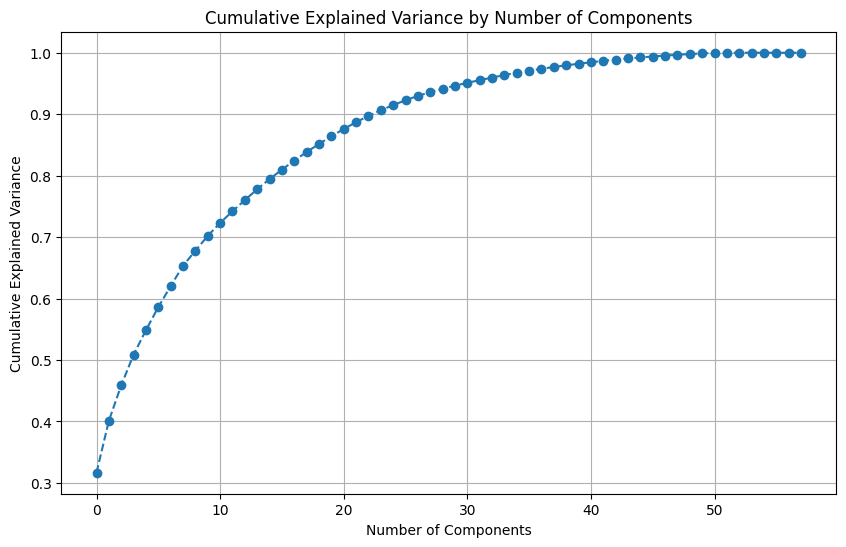

In [954]:
def pca(df):
    # drop the irrelevant terms
    featuresToDrop = ['Date', 'Home Team', 'Away Team', 'Full Time Result', 'Half Time Result', 'Referee']
    assert set(featuresToDrop).issubset(df.columns), "Some columns in featuresToDrop are missing in df"
    df2 = df.drop(featuresToDrop, axis=1)
    
    df2 = standardisation(df2, terms=list(df2.columns))
    
    pca = PCA()
    pca_components = pca.fit_transform(df2)
    
    # find the explained variance ratio
    explained_variance = pca.explained_variance_ratio_
    print("Explained Variance Ratio: ", explained_variance)

    # select number of components based on explained variance (e.g., 95% variance)
    cumulative_variance = explained_variance.cumsum()
    n_components = next(i for i, v in enumerate(cumulative_variance) if v >= 0.95) + 1
    print(f"Number of components to retain 95% variance: {n_components}")

    # visualize explained variance
    plt.figure(figsize=(10, 6))
    plt.plot(cumulative_variance, marker='o', linestyle='--')
    plt.title('Cumulative Explained Variance by Number of Components')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.grid()
    plt.show()
    
    return n_components
    
number_of_components = pca(df)

Next, we reduced the feature data set to 5 sections of inputs: Home Advantage, Attacking Strength, Midfield Strength, Defensive Strength, and extras. 

Discarded features include: 

'Half Time Home Goals', 'Half Time Away Goals', 'Half Time Result', 'Referee', 'Home Shots', 'Away Shots', 'Home Fouls', 'Away Fouls', 'Home Yellow Cards', 'Away Yellow Cards', 'Home Red Cards', 'Away Red Cards', 'Home Possession', 'Away Possession', 'Home Progressive Passing Distance', 'Home xG', 'Home Take Ons', 'Home Touches', 'Home Touches Def 3rd', 'Home Carries Progressive Distance', 'Away Progressive Passing Distance', 'Away xG', 'Away Take Ons', 'Away Touches', 'Away Touches Def 3rd', 'Away Carries Progressive Distance', 'Season', 'Home Team Points', 'Away Team Points', 'Home Total Seasonal Points', 'Away Total Seasonal Points'

In [955]:
features = [
    # Home Advantage
    "Home Team",
    "Away Team",
    "Match Outcome",
    "Full Time Home Goals",
    "Full Time Away Goals",
    
    # Attacking Strength
    "Home Shots on Target", "Away Shots on Target",
    "Home Progressive Passes", "Away Progressive Passes",
    "Home Touches Att 3rd", "Away Touches Att 3rd",
    "Home Take Ons Won", "Away Take Ons Won",
    "Home Corners", "Away Corners",
    
    # Midfield Strength
    "Home Touches Mid 3rd", "Away Touches Mid 3rd",
    "Home Passes Completed", "Away Passes Completed",
    "Home Passes PCT", "Away Passes PCT",
    "Home Carries", "Away Carries",
    
    # Defensive Strength
    "Home Tackles", "Away Tackles",
    "Home Tackles Won", "Away Tackles Won",
    "Home Blocks", "Away Blocks",
    "Home Interceptions", "Away Interceptions",
    
    # Extra
    "Full Time Result",
    'Date'
]

new_df = df[features].copy()
new_df.dropna(inplace=True)

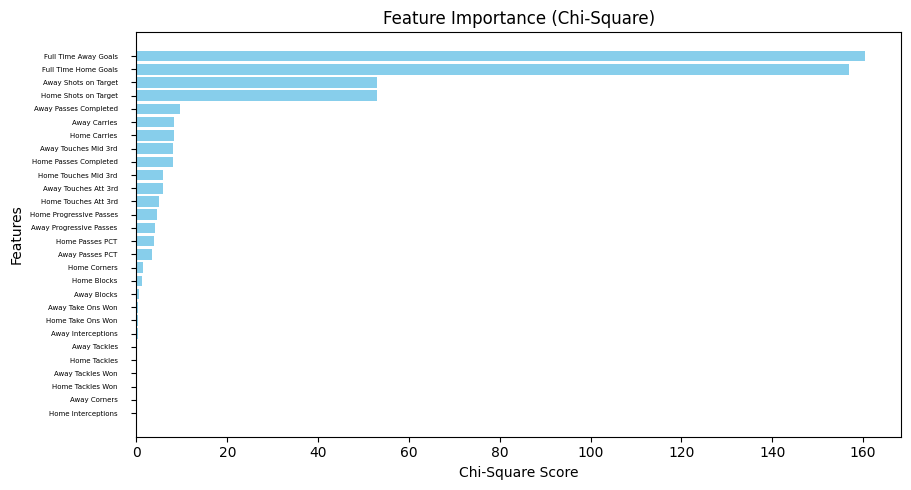

In [956]:
def chi_square(df):
    # organise dataset into X (training examples) and y (targets)
    featuresToDrop = ['Date', 'Home Team', 'Full Time Result', 'Away Team', 'Match Outcome']
    assert set(featuresToDrop).issubset(df.columns), "Some columns in featuresToDrop are missing in df"
    data = df.drop(featuresToDrop, axis=1)
    df['Match Outcome'] = df['Full Time Result'].map({'H': 1, 'D': 0, 'A': -1})
    target = df['Match Outcome']
    
    # chi2 scoring function requires non-negative input: normalisation
    data = normalisation(data, terms=list(data.columns))
    
    # collect the feature names
    feature_names = list(data.columns)
    
    # perform chi square selection    
    chi_select = SelectKBest(chi2, k=min(number_of_components, len(data.columns)))
    new_data = chi_select.fit_transform(data, target)
    
    # collect features
    selected_features = []
    for i, b in enumerate(chi_select.get_support()):
        if b:
            selected_features.append(feature_names[i])
    
    # get the chi-square scores for all features
    chi_scores = chi_select.scores_

    # create a dataFrame for easy visualization
    chi2_df = pd.DataFrame({'Feature': feature_names, 'Chi-Square Score': chi_scores})
    chi2_df = chi2_df.sort_values(by='Chi-Square Score', ascending=False)

    # plot the scores
    plt.figure(figsize=(10, 5))
    colours = ['skyblue' if i < number_of_components else 'gray' for i in range(len(chi2_df))]
    plt.barh(chi2_df['Feature'], chi2_df['Chi-Square Score'], color=colours)
    plt.xlabel('Chi-Square Score')
    plt.ylabel('Features')
    plt.title('Feature Importance (Chi-Square)')
    plt.gca().invert_yaxis()  # Invert y-axis to show the highest scores at the top
    plt.tight_layout()
    plt.tick_params(axis="y", pad=10, labelsize=5)
    plt.show()
    
    return chi2_df
    
chi2_df = chi_square(new_df)   

Now we will take the feature importance scores from the Chi-Square distribution and adjust the weights to approach a gradual steady decline. This will allow the less important features to contribute to our feature engineering later while preserving a hierarchical ranking. 

Note: the number 1/3 was chosen arbitrarily but it was observed to be a standard heuristic among Machine Learning papers.

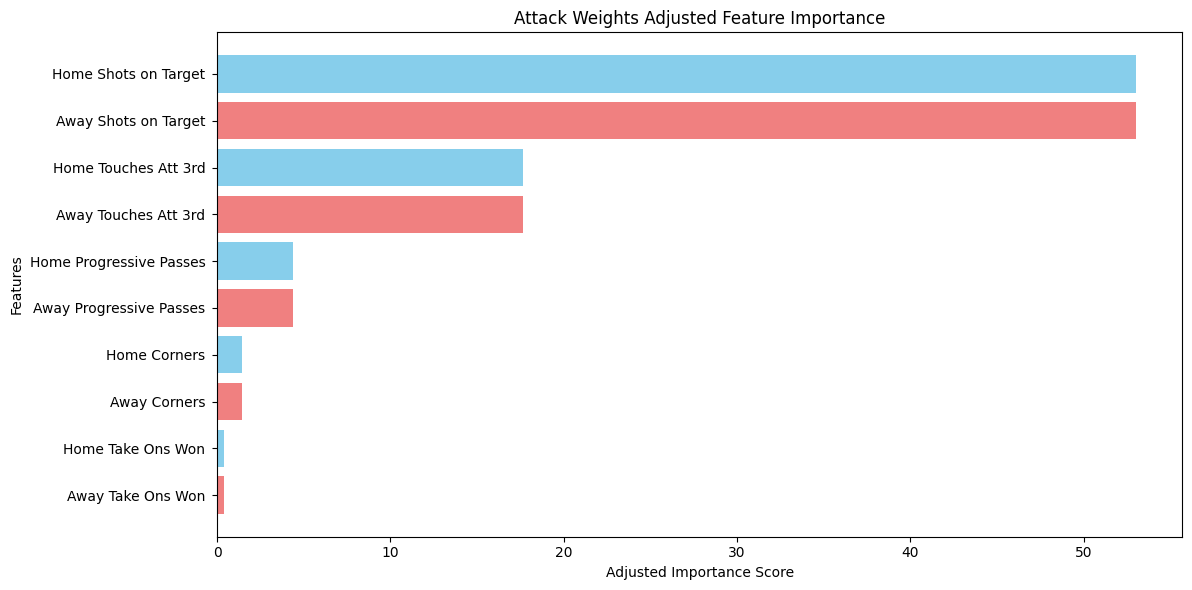

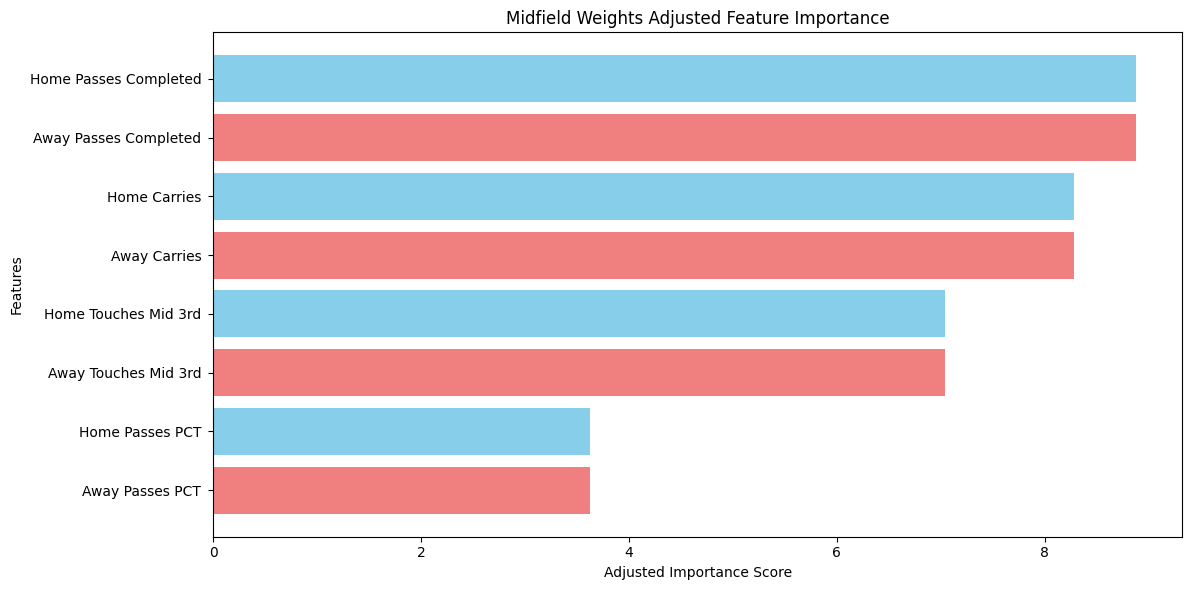

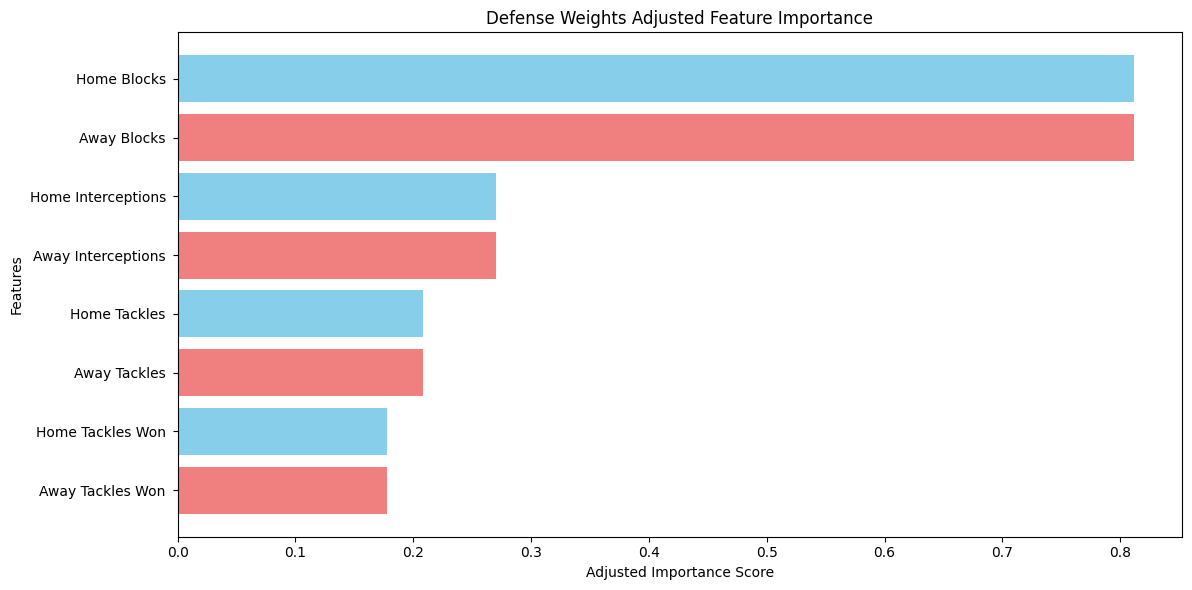

In [957]:
def adjust_feature_weights(features, chi2_df):
    # Aggregate Home and Away importance scores
    aggregated_scores = {}
    for feature_pair in features:
        home_feature, away_feature = feature_pair
        home_score = chi2_df.loc[chi2_df['Feature'] == home_feature, 'Chi-Square Score'].values[0]
        away_score = chi2_df.loc[chi2_df['Feature'] == away_feature, 'Chi-Square Score'].values[0]
        aggregated_scores[feature_pair] = home_score + away_score

    # Sort features by aggregated importance
    sorted_features = sorted(aggregated_scores.items(), key=lambda x: x[1], reverse=True)
    
    # Adjust scores using the /3 rule
    adjusted_scores = {}
    adjusted_scores[sorted_features[0][0]] = sorted_features[0][1]  # Most important feature remains unchanged
    
    for i in range(1, len(sorted_features)):
        current_feature, current_score = sorted_features[i]
        previous_feature, previous_score = sorted_features[i - 1]
        
        if current_score < previous_score / 3:
            current_score = previous_score / 3
        adjusted_scores[current_feature] = current_score

    # Assign adjusted scores equally to Home and Away features
    final_weights = {}
    for feature_pair, score in adjusted_scores.items():
        home_feature, away_feature = feature_pair
        final_weights[home_feature] = score / 2
        final_weights[away_feature] = score / 2
    
    return final_weights

def plot_adjusted_features(weights, title):
    # prepare data for plotting
    features = list(weights.keys())
    importance = list(weights.values())

    # create the plot
    plt.figure(figsize=(12, 6))
    colours = ['skyblue' if 'Home' in feature else 'lightcoral' for feature in features]
    plt.barh(features, importance, color=colours)

    # customize the plot
    plt.xlabel('Adjusted Importance Score')
    plt.ylabel('Features')
    plt.title(title)
    plt.gca().invert_yaxis()  # highest scores at the top
    plt.tight_layout()
    plt.tick_params(axis="y", pad=5, labelsize=10)  # adjust y-axis label size for better visibility
    plt.show()


def create_strength_features_separate(df, chi2_df):
    # Define feature pairs for each group
    attack_features = [
        ("Home Shots on Target", "Away Shots on Target"),
        ("Home Progressive Passes", "Away Progressive Passes"),
        ("Home Touches Att 3rd", "Away Touches Att 3rd"),
        ("Home Take Ons Won", "Away Take Ons Won"),
        ("Home Corners", "Away Corners")
    ]
    midfield_features = [
        ("Home Touches Mid 3rd", "Away Touches Mid 3rd"),
        ("Home Passes Completed", "Away Passes Completed"),
        ("Home Passes PCT", "Away Passes PCT"),
        ("Home Carries", "Away Carries")
    ]
    defense_features = [
        ("Home Tackles", "Away Tackles"),
        ("Home Tackles Won", "Away Tackles Won"),
        ("Home Blocks", "Away Blocks"),
        ("Home Interceptions", "Away Interceptions")
    ]
    
    # Adjust weights for each group
    attack_weights = adjust_feature_weights(attack_features, chi2_df)
    midfield_weights = adjust_feature_weights(midfield_features, chi2_df)
    defense_weights = adjust_feature_weights(defense_features, chi2_df)
    
    plot_adjusted_features(attack_weights, "Attack Weights Adjusted Feature Importance")
    plot_adjusted_features(midfield_weights, "Midfield Weights Adjusted Feature Importance")
    plot_adjusted_features(defense_weights, "Defense Weights Adjusted Feature Importance")
    
    # Calculate strength scores for Home and Away
    def calculate_strength(feature_pairs, weights, team_type):
        strength_score = 0
        for home_feature, away_feature in feature_pairs:
            feature = home_feature if team_type == "Home" else away_feature
            strength_score += df[feature] * weights[feature]
        return strength_score

    # Compute Home and Away strengths for Attack, Midfield, and Defense
    df['Home Attack Strength'] = calculate_strength(attack_features, attack_weights, "Home")
    df['Away Attack Strength'] = calculate_strength(attack_features, attack_weights, "Away")
    df['Home Midfield Strength'] = calculate_strength(midfield_features, midfield_weights, "Home")
    df['Away Midfield Strength'] = calculate_strength(midfield_features, midfield_weights, "Away")
    df['Home Defense Strength'] = calculate_strength(defense_features, defense_weights, "Home")
    df['Away Defense Strength'] = calculate_strength(defense_features, defense_weights, "Away")
    
    return df



strength_df = create_strength_features_separate(new_df, chi2_df)

In [958]:
def avg_stats_last_x_games(df):
    
    def calculate_running_avg(stats_list, x):
        if len(stats_list) < x:
            return None
        return sum(stats_list[-x:]) / x

    metrics = ['Goals Scored', 'Goals Conceded', 'Attack Strength', 'Midfield Strength', 'Defense Strength', 'Recent Performance']# , 'xG', 'Disciplinary Pressure']
    for metric in metrics:
        for x in range(1, RECENCY_NUM + 1):
            df[f'Avg {metric} Home Last {x} Games'] = None
            df[f'Avg {metric} Away Last {x} Games'] = None
    running_stats = {}

    for idx, row in df.iterrows():
        for team_type in ['Home Team', 'Away Team']:
            team = row[team_type]
            stat_type = team_type.split()[0]  # Home or Away

            if team not in running_stats:
                running_stats[team] = {
                    'Goals Scored': [],
                    'Goals Conceded': [],
                    'Attack Strength': [],
                    'Midfield Strength': [],
                    'Defense Strength': [],
                    #'Disciplinary Pressure': [],
                    'Recent Performance': []
                }

            team_stats = running_stats[team]

            for x in range(1, RECENCY_NUM + 1):
                for metric in metrics:
                    avg_stat = calculate_running_avg(team_stats[metric], x)
                    df.at[idx, f'Avg {metric} {stat_type} Last {x} Games'] = avg_stat
            team_stats['Goals Scored'].append(row['Full Time Home Goals'] if stat_type == 'Home' else row['Full Time Away Goals'])
            team_stats['Goals Conceded'].append(row['Full Time Away Goals'] if stat_type == 'Home' else row['Full Time Home Goals'])
            team_stats['Attack Strength'].append(row['Home Attack Strength'] if stat_type == 'Home' else row['Away Attack Strength'])
            team_stats['Midfield Strength'].append(row['Home Midfield Strength'] if stat_type == 'Home' else row['Away Midfield Strength'])
            team_stats['Defense Strength'].append(row['Home Defense Strength'] if stat_type == 'Home' else row['Away Defense Strength'])
            #team_stats['xG'].append(row['xG Home'] if stat_type == 'Home' else row['xG Away'])
            #team_stats['Disciplinary Pressure'].append(row['Home Disciplinary Pressure'] if stat_type == 'Home' else row['Away Disciplinary Pressure'])
            team_stats['Recent Performance'].append(1 if (row['Full Time Result'] == 'H' and stat_type == 'Home') or (row['Full Time Result'] == 'A' and stat_type == 'Away') else 0.5 if row['Full Time Result'] == 'D' else 0)
    return df

df = avg_stats_last_x_games(strength_df)
original_size = len(df)
df.dropna(inplace=True)    # removes the matches without enough X previous data
new_size = len(df)

print(f"By removing the first 5 games of each team, we are left with {new_size}/{original_size} games.")
print(f"We lost {1-float(new_size)/original_size:.2%}")

By removing the first 5 games of each team, we are left with 2660/2760 games.
We lost 3.62%


The below code fixes our dataset to only include Recency features. The original dataset is kept as a copy.

In [959]:
features = [
    'Avg Goals Scored Home Last 1 Games',
       'Avg Goals Scored Away Last 1 Games',
       'Avg Goals Scored Home Last 2 Games',
       'Avg Goals Scored Away Last 2 Games',
       'Avg Goals Scored Home Last 3 Games',
       'Avg Goals Scored Away Last 3 Games',
       'Avg Goals Scored Home Last 4 Games',
       'Avg Goals Scored Away Last 4 Games',
       'Avg Goals Scored Home Last 5 Games',
       'Avg Goals Scored Away Last 5 Games',
       'Avg Goals Conceded Home Last 1 Games',
       'Avg Goals Conceded Away Last 1 Games',
       'Avg Goals Conceded Home Last 2 Games',
       'Avg Goals Conceded Away Last 2 Games',
       'Avg Goals Conceded Home Last 3 Games',
       'Avg Goals Conceded Away Last 3 Games',
       'Avg Goals Conceded Home Last 4 Games',
       'Avg Goals Conceded Away Last 4 Games',
       'Avg Goals Conceded Home Last 5 Games',
       'Avg Goals Conceded Away Last 5 Games',
       'Avg Attack Strength Home Last 1 Games',
       'Avg Attack Strength Away Last 1 Games',
       'Avg Attack Strength Home Last 2 Games',
       'Avg Attack Strength Away Last 2 Games',
       'Avg Attack Strength Home Last 3 Games',
       'Avg Attack Strength Away Last 3 Games',
       'Avg Attack Strength Home Last 4 Games',
       'Avg Attack Strength Away Last 4 Games',
       'Avg Attack Strength Home Last 5 Games',
       'Avg Attack Strength Away Last 5 Games',
       'Avg Midfield Strength Home Last 1 Games',
       'Avg Midfield Strength Away Last 1 Games',
       'Avg Midfield Strength Home Last 2 Games',
       'Avg Midfield Strength Away Last 2 Games',
       'Avg Midfield Strength Home Last 3 Games',
       'Avg Midfield Strength Away Last 3 Games',
       'Avg Midfield Strength Home Last 4 Games',
       'Avg Midfield Strength Away Last 4 Games',
       'Avg Midfield Strength Home Last 5 Games',
       'Avg Midfield Strength Away Last 5 Games',
       'Avg Defense Strength Home Last 1 Games',
       'Avg Defense Strength Away Last 1 Games',
       'Avg Defense Strength Home Last 2 Games',
       'Avg Defense Strength Away Last 2 Games',
       'Avg Defense Strength Home Last 3 Games',
       'Avg Defense Strength Away Last 3 Games',
       'Avg Defense Strength Home Last 4 Games',
       'Avg Defense Strength Away Last 4 Games',
       'Avg Defense Strength Home Last 5 Games',
       'Avg Defense Strength Away Last 5 Games',
       'Avg Recent Performance Home Last 1 Games',
       'Avg Recent Performance Away Last 1 Games',
       'Avg Recent Performance Home Last 2 Games',
       'Avg Recent Performance Away Last 2 Games',
       'Avg Recent Performance Home Last 3 Games',
       'Avg Recent Performance Away Last 3 Games',
       'Avg Recent Performance Home Last 4 Games',
       'Avg Recent Performance Away Last 4 Games',
       'Avg Recent Performance Home Last 5 Games',
       'Avg Recent Performance Away Last 5 Games',
       'Home Team',
       'Match Outcome',
       'Date'
]
original_df = df.copy()
df = df[features]

# Feature Selection

In [960]:
with pd.option_context('display.max_rows', 10, 'display.max_columns', None): 
    display(df)

Avg Goals Scored Home Last 1 Games Avg Goals Scored Away Last 1 Games  \
57                                  0.0                                0.0   
56                                  0.0                                0.0   
55                                  1.0                                0.0   
54                                  1.0                                4.0   
53                                  6.0                                0.0   
...                                 ...                                ...   
2752                                1.0                                3.0   
2751                                2.0                                2.0   
2750                                1.0                                1.0   
2753                                1.0                                2.0   
2759                                0.0                                0.0   

     Avg Goals Scored Home Last 2 Games Avg Goals Scored Away Last 2 Games  \
57                                  1.0                                1.5   
56                                  0.0                                1.0   
55                                  1.5                                1.0   
54                                  0.5                                3.0   
53                                  5.5                                0.0   
...                                 ...                                ...   
2752                                1.0                                1.5   
2751                                1.0                                1.5   
2750                                2.0                                1.0   
2753                                1.0                                2.5   
2759                                0.5                                1.0   

     Avg Goals Scored Home Last 3 Games Avg Goals Scored Away Last 3 Games  \
57                             0.666667                           1.333333   
56                             0.666667                           0.666667   
55                             1.333333                           1.333333   
54                             0.333333                           2.666667   
53                             4.333333                                0.0   
...                                 ...                                ...   
2752                                1.0                                1.0   
2751                           0.666667                           2.333333   
2750                           2.333333                                1.0   
2753                                1.0                           1.666667   
2759                           0.666667                           1.333333   

     Avg Goals Scored Home Last 4 Games Avg Goals Scored Away Last 4 Games  \
57                                  1.0                               1.25   
56                                  0.5                                1.0   
55                                 1.25                                1.5   
54                                  1.0                                3.0   
53                                  3.5                                0.0   
...                                 ...                                ...   
2752                               0.75                                1.0   
2751                               1.75                                3.0   
2750                                3.0                               1.25   
2753                               1.75                               1.25   
2759                                1.0                                1.0   

     Avg Goals Scored Home Last 5 Games Avg Goals Scored Away Last 5 Games  \
57                                  0.8                                1.4   
56                                  0.4                                1.4   
55                     

The first method of feature selection that we will look at is Recursive Feature Engineering. This (supervised) wrapper method starts with the full model. RFE then uses the model’s feature importance (model weights, coefficients) to decide which feature to remove – recursively extracting features until the desired data table is reached. 

RFE fits the data to a specific model. Here we will look at feature selection in regard to Logistic Regression. Because of this model selection, our data is standardised beforehand. 

Selected Features by RFE (LR):
['Avg Goals Scored Away Last 1 Games', 'Avg Goals Scored Home Last 2 Games', 'Avg Goals Scored Away Last 2 Games', 'Avg Goals Scored Home Last 3 Games', 'Avg Goals Scored Away Last 3 Games', 'Avg Goals Scored Home Last 5 Games', 'Avg Goals Conceded Away Last 1 Games', 'Avg Goals Conceded Away Last 2 Games', 'Avg Goals Conceded Home Last 3 Games', 'Avg Goals Conceded Home Last 4 Games', 'Avg Goals Conceded Away Last 4 Games', 'Avg Goals Conceded Away Last 5 Games', 'Avg Attack Strength Away Last 2 Games', 'Avg Attack Strength Away Last 3 Games', 'Avg Attack Strength Home Last 4 Games', 'Avg Attack Strength Away Last 4 Games', 'Avg Attack Strength Away Last 5 Games', 'Avg Midfield Strength Away Last 2 Games', 'Avg Midfield Strength Home Last 3 Games', 'Avg Midfield Strength Away Last 3 Games', 'Avg Midfield Strength Home Last 4 Games', 'Avg Midfield Strength Away Last 4 Games', 'Avg Midfield Strength Home Last 5 Games', 'Avg Recent Performance Home Last 1 G

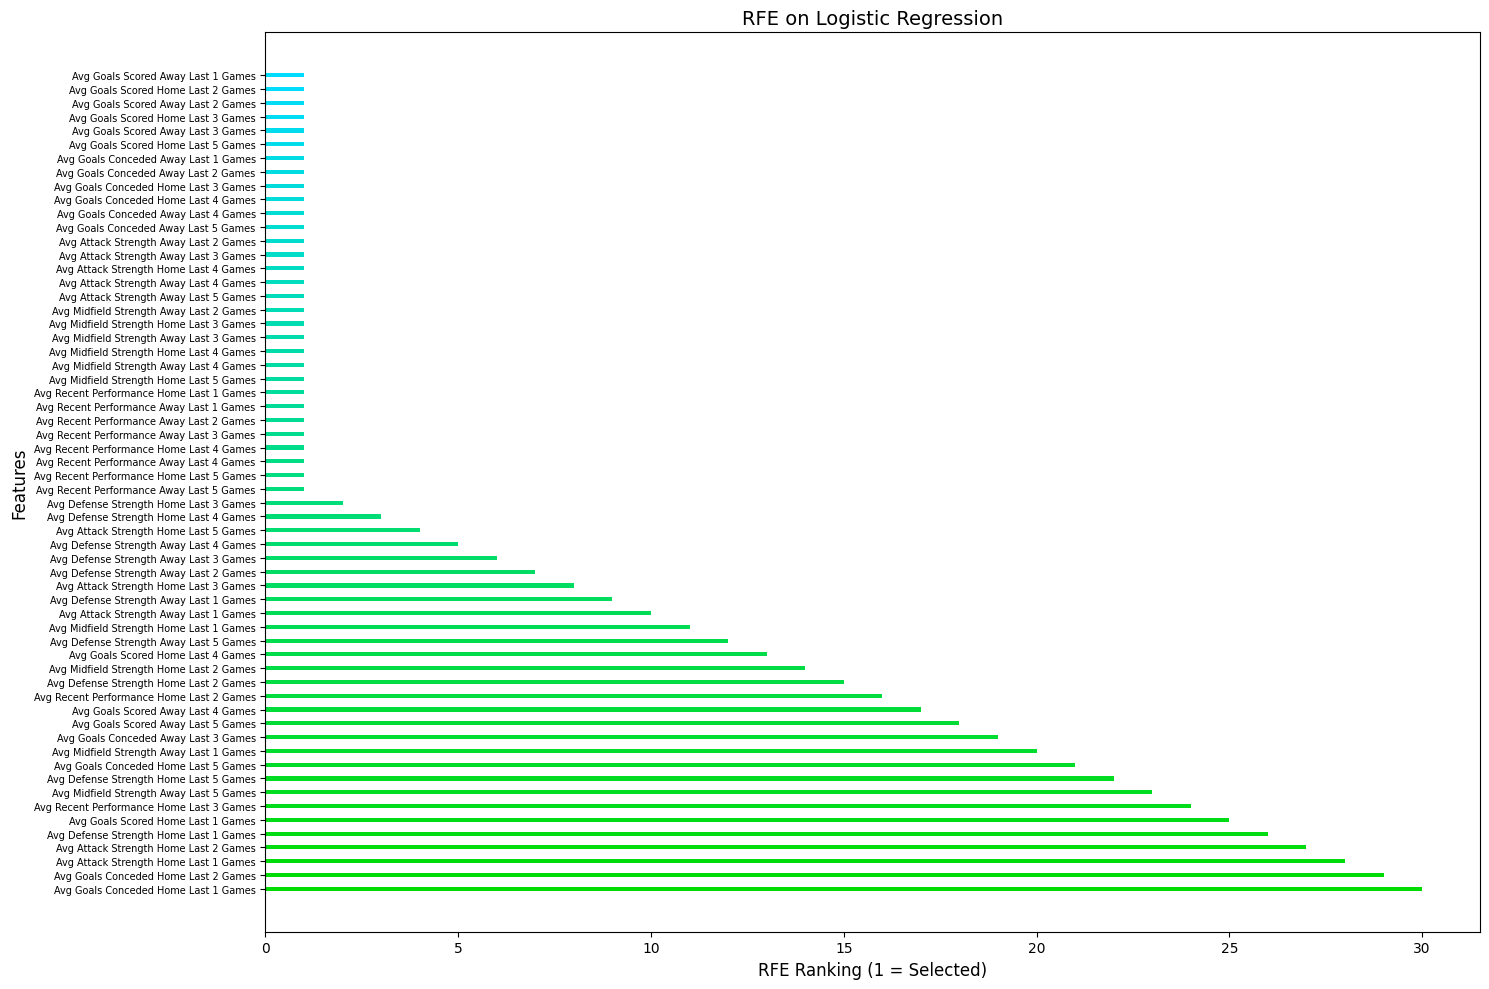

In [961]:
def recursive_feature_elimination_LR(df):
    # organise dataset into X (training examples) and y (targets)
    featuresToDrop = ['Date', 'Match Outcome', 'Home Team']
    assert set(featuresToDrop).issubset(df.columns), "Some columns in featuresToDrop are missing in df"
    data = df.drop(featuresToDrop, axis=1)
    target = df['Match Outcome']
    
    data = standardisation(data, terms=list(data.columns))
    
    # collect the feature names
    feature_names = list(data.columns)
        
    # perform RFE
    rfe = RFE(estimator=LogisticRegression(max_iter=500), n_features_to_select=number_of_components) # taken from PCA
    rfe.fit(data, target)
    
    # get feature rankings and selected features
    feature_ranking = rfe.ranking_
    selected_features = [feature for feature, rank in zip(feature_names, feature_ranking) if rank == 1]
    
    print("Selected Features by RFE (LR):")
    print(selected_features)
    
    # plot feature rankings
    plt.figure(figsize=(15, 10))
    sorted_features = sorted(zip(feature_names, feature_ranking), key=lambda x: x[1])
    sorted_names, sorted_ranks = zip(*sorted_features)

    # increase spacing between bars
    y_positions = np.arange(len(sorted_names)) * 2
    bar_height = 0.6

    # generate gradient colors from blue to green
    colors = [(0, 220/255, 1 - alpha) for alpha in np.linspace(0, 1, len(sorted_ranks))]

    # plot horizontal bar chart with gradient colors
    for ypos, rank, color in zip(y_positions, sorted_ranks, colors):
        plt.barh(ypos, rank, height=bar_height, color=color)

    plt.yticks(y_positions, sorted_names, fontsize=7)
    plt.xlabel("RFE Ranking (1 = Selected)", fontsize=12)
    plt.ylabel("Features", fontsize=12)
    plt.title("RFE on Logistic Regression", fontsize=14)

    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show() 
    
    return selected_features
            
    

logistic_features = recursive_feature_elimination_LR(df)

Next, we will look at feature selection methods for K Nearest Neighbours. As this model does not work with RFE, we will have to look at other methods. Predictions for KNN are based on the distance between data points and are therefore highly sensitive to redundant features. 

We will begin with Variance Thresholding (removing low variance features) and then apply a filter method Mutual Information (measuring non-linear relationships between the features and targets).

Variance Minimum:  0.013576172443849375  ---->  Variance Maximum:  0.19291592322287476


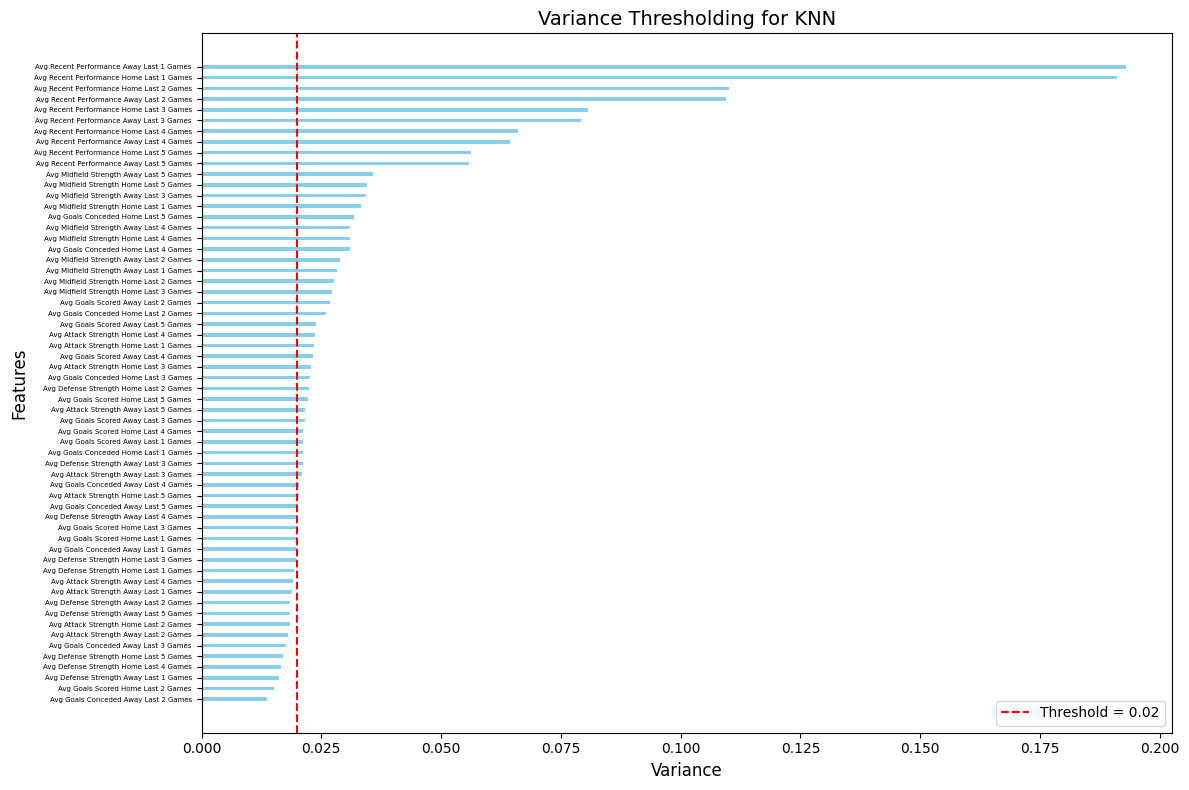

Reduced Data:  42 / 60

Removed Features and Their Variances:
---------------------------------------

Avg Defense Strength Away Last 4 Games    0.019936
Avg Goals Scored Home Last 3 Games        0.019916
Avg Goals Scored Home Last 1 Games        0.019838
Avg Goals Conceded Away Last 1 Games      0.019695
Avg Defense Strength Home Last 3 Games    0.019652
Avg Defense Strength Home Last 1 Games    0.019304
Avg Attack Strength Away Last 4 Games     0.019068
Avg Attack Strength Away Last 1 Games     0.018819
Avg Defense Strength Away Last 2 Games    0.018565
Avg Defense Strength Away Last 5 Games    0.018394
Avg Attack Strength Home Last 2 Games     0.018377
Avg Attack Strength Away Last 2 Games     0.018090
Avg Goals Conceded Away Last 3 Games      0.017666
Avg Defense Strength Home Last 5 Games    0.017037
Avg Defense Strength Home Last 4 Games    0.016667
Avg Defense Strength Away Last 1 Games    0.016143
Avg Goals Scored Home Last 2 Games        0.015106
Avg Goals Conceded Away Last 2

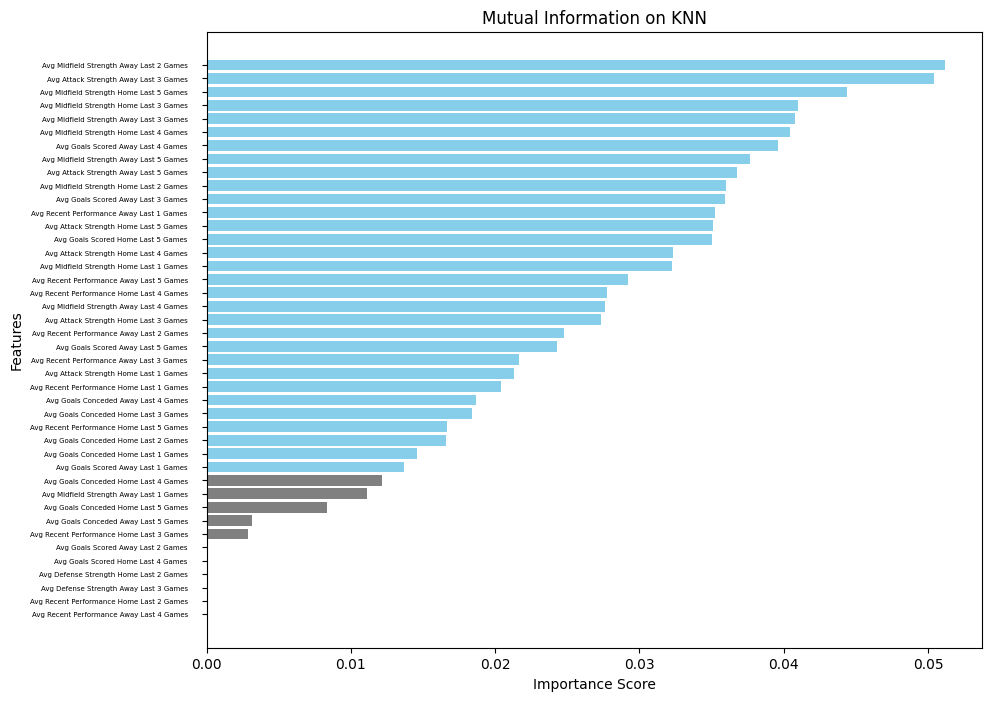


Selected Features for KNN:
['Avg Midfield Strength Away Last 2 Games', 'Avg Attack Strength Away Last 3 Games', 'Avg Midfield Strength Home Last 5 Games', 'Avg Midfield Strength Home Last 3 Games', 'Avg Midfield Strength Away Last 3 Games', 'Avg Midfield Strength Home Last 4 Games', 'Avg Goals Scored Away Last 4 Games', 'Avg Midfield Strength Away Last 5 Games', 'Avg Attack Strength Away Last 5 Games', 'Avg Midfield Strength Home Last 2 Games', 'Avg Goals Scored Away Last 3 Games', 'Avg Recent Performance Away Last 1 Games', 'Avg Attack Strength Home Last 5 Games', 'Avg Goals Scored Home Last 5 Games', 'Avg Attack Strength Home Last 4 Games', 'Avg Midfield Strength Home Last 1 Games', 'Avg Recent Performance Away Last 5 Games', 'Avg Recent Performance Home Last 4 Games', 'Avg Midfield Strength Away Last 4 Games', 'Avg Attack Strength Home Last 3 Games', 'Avg Recent Performance Away Last 2 Games', 'Avg Goals Scored Away Last 5 Games', 'Avg Recent Performance Away Last 3 Games', 'Avg At

In [969]:
def knn_feature_selection(df):
    
    # first step is calculating minimal variance features
    def variance_thresholding(data, threshold=0.02):
        variances = data.var()
        print("Variance Minimum: ", variances.min(), " ---->  Variance Maximum: ", variances.max())
    
        # filter features based on the threshold
        retained_features = variances[variances >= threshold].index
        reduced_data = data[retained_features]
        sorted_variances = variances.sort_values(ascending=False)

        # plot horizontal bar graph for feature variances
        plt.figure(figsize=(12, 8))
        y_positions = np.arange(len(sorted_variances)) * 3  # increase spacing between bars
        plt.barh(y_positions, sorted_variances, color='skyblue', height=1.0)
        plt.gca().invert_yaxis()
        
        # add a threshold line
        plt.axvline(x=threshold, color='red', linestyle='--', label=f'Threshold = {threshold}')
        
        plt.yticks(y_positions, sorted_variances.index, fontsize=5)
        plt.xlabel('Variance', fontsize=12)
        plt.ylabel('Features', fontsize=12)
        plt.title('Variance Thresholding for KNN', fontsize=14)
        plt.legend(fontsize=10)
        plt.tight_layout()
        plt.show()
        

        # print removed features and their variances
        removed_features = sorted_variances[sorted_variances < threshold]
        print("Reduced Data: ", len(reduced_data.columns), "/", len(data.columns))
        print("\nRemoved Features and Their Variances:")
        print("---------------------------------------\n")
        print(removed_features, "\n")
        
        return reduced_data
    
    # second step is mutual information between features and target
    def mutual_info(data, target):
        # apply information gain
        gain = mutual_info_regression(data, target)

        # dictionary of feature importance scores
        feature_names = list(data.columns)
        scores = {}
        for i in range(len(feature_names)):
            scores[feature_names[i]] = gain[i]

        # descending sort by importance score
        sorted_features = sorted(scores.items(), key=lambda x:x[1], reverse=True)

#         print("\nMutual Information Importance Score: ")
#         print("------------------------------------\n")
#         for feature, score in sorted_features:
#             print(f"{feature + ' score:':55}\t{score:.16f}")

        # plot a bar chat of feature importance scores
        fig, ax = plt.subplots(figsize=(10, 8))
        y_pos = np.arange(len(sorted_features))
        colours = ['skyblue' if i < number_of_components else 'gray' for i in range(len(sorted_features))]
        ax.barh(y_pos, [score for feature, score in sorted_features], align="center", color=colours)
        ax.set_yticks(y_pos)
        ax.set_yticklabels([feature for feature, score in sorted_features])
        ax.invert_yaxis()  # Labels read top-to-bottom
        ax.set_xlabel("Importance Score")
        ax.set_ylabel('Features')
        ax.set_title("Mutual Information on KNN")
        ax.tick_params(axis="y", pad=10, labelsize=5)
        plt.show()
        
        # returns most important features
        selected_features = [feature for feature, _ in sorted_features[:number_of_components]]
        print("\nSelected Features for KNN:")
        print(selected_features)
        return selected_features
        
    
    # organise dataset into X (training examples) and y (targets)
    featuresToDrop = ['Date', 'Match Outcome', 'Home Team']
    assert set(featuresToDrop).issubset(df.columns), "Some columns in featuresToDrop are missing in df"
    data = df.drop(featuresToDrop, axis=1)
    
    # normalise the data to put all the variances on the same scale
    # otherwise the difference between variances would be 0.0558 to 8728992.4427
    data = normalisation(data, terms=list(data.columns))
    
    variance_data = variance_thresholding(data)
    
    # use label encoding on the target data, keep it discrete
    target = df['Match Outcome']
    target = label_encoding(target, dataframe=False)
    
    return mutual_info(variance_data, target)
    

knn_features = knn_feature_selection(df)

Next is Recursive Feature Engineering for SVM. It will be a repeat of the last function, this time using a SVM model for feature selection. 

Selected Features by RFE (SVM):
['Avg Goals Scored Away Last 1 Games', 'Avg Goals Scored Home Last 2 Games', 'Avg Goals Scored Away Last 2 Games', 'Avg Goals Scored Home Last 3 Games', 'Avg Goals Scored Away Last 3 Games', 'Avg Goals Conceded Away Last 1 Games', 'Avg Goals Conceded Away Last 2 Games', 'Avg Goals Conceded Away Last 4 Games', 'Avg Attack Strength Away Last 2 Games', 'Avg Attack Strength Home Last 3 Games', 'Avg Attack Strength Away Last 3 Games', 'Avg Attack Strength Home Last 4 Games', 'Avg Attack Strength Away Last 4 Games', 'Avg Attack Strength Home Last 5 Games', 'Avg Attack Strength Away Last 5 Games', 'Avg Midfield Strength Away Last 2 Games', 'Avg Midfield Strength Home Last 3 Games', 'Avg Midfield Strength Home Last 4 Games', 'Avg Midfield Strength Home Last 5 Games', 'Avg Midfield Strength Away Last 5 Games', 'Avg Defense Strength Home Last 3 Games', 'Avg Defense Strength Home Last 4 Games', 'Avg Defense Strength Away Last 4 Games', 'Avg Defense Strength Away La

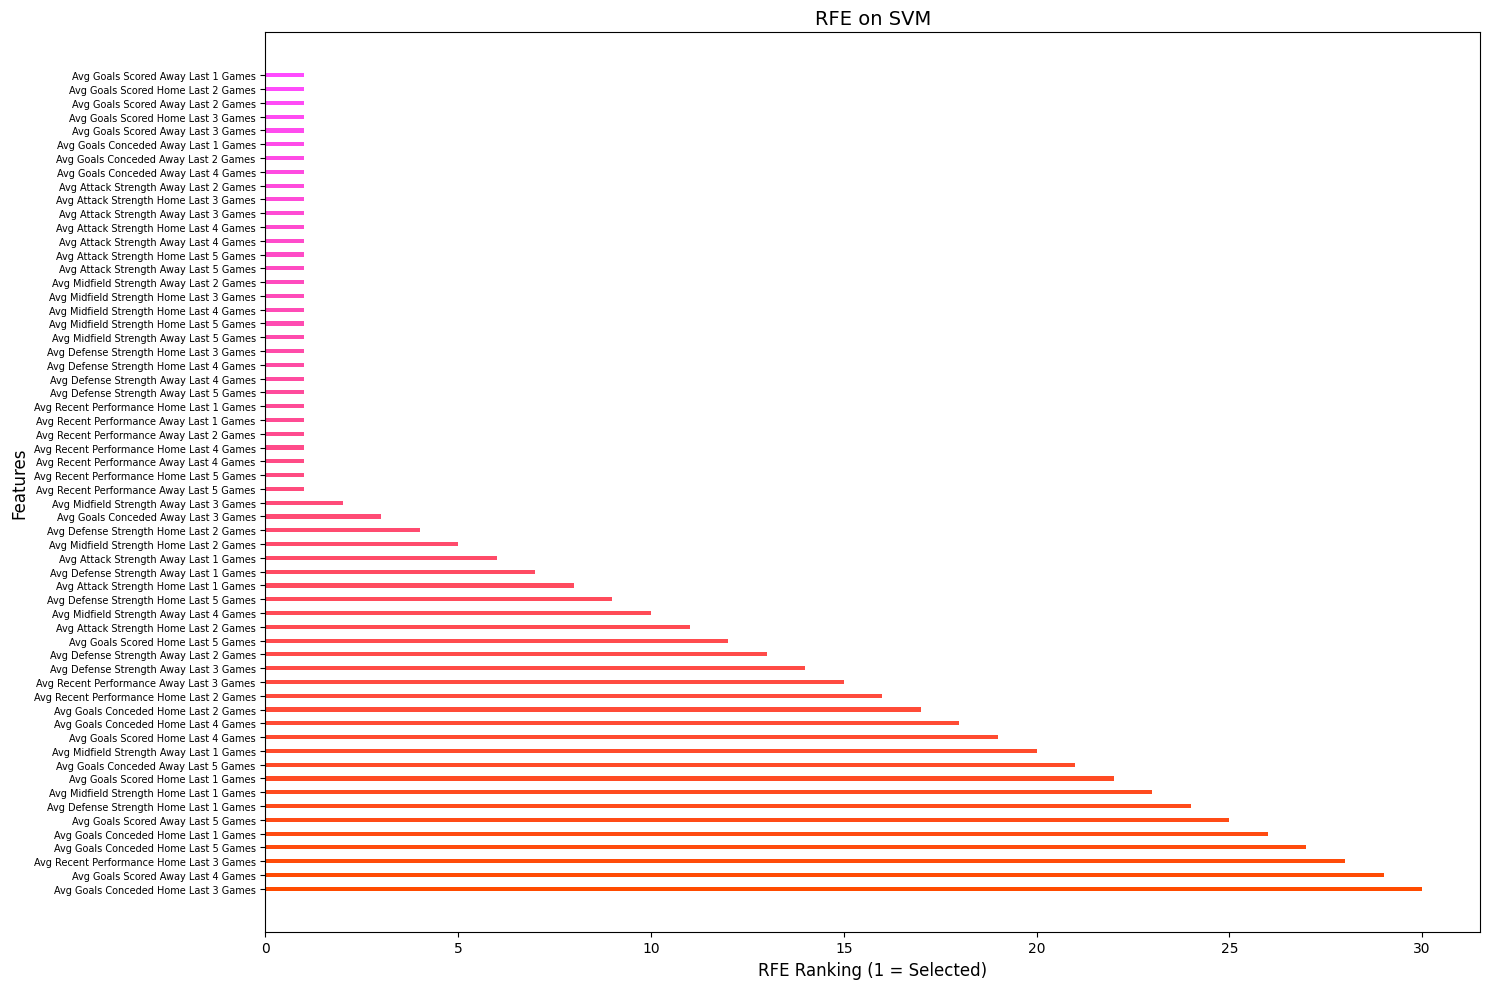

In [964]:
def recursive_feature_elimination_svm(df):
    # organise dataset into X (training examples) and y (targets)
    featuresToDrop = ['Date', 'Match Outcome', 'Home Team']
    assert set(featuresToDrop).issubset(df.columns), "Some columns in featuresToDrop are missing in df"
    data = df.drop(featuresToDrop, axis=1)
    target = df['Match Outcome']
    
    data = standardisation(data, terms=list(data.columns))
    
    # collect the feature names
    feature_names = list(data.columns)
        
    # perform RFE
    rfe = RFE(estimator=SVC(kernel="linear"), n_features_to_select=number_of_components) # taken from PCA
    rfe.fit(data, target)
    
    # get feature rankings and selected features
    feature_ranking = rfe.ranking_
    selected_features = [feature for feature, rank in zip(feature_names, feature_ranking) if rank == 1]
    
    print("Selected Features by RFE (SVM):")
    print(selected_features)
    
    # plot feature rankings
    plt.figure(figsize=(15, 10))
    sorted_features = sorted(zip(feature_names, feature_ranking), key=lambda x: x[1])
    sorted_names, sorted_ranks = zip(*sorted_features)

    # increase spacing between bars
    y_positions = np.arange(len(sorted_names)) * 2
    bar_height = 0.6

    # generate gradient colors from blue to green
    colors = [(1, 75/255, 1 - alpha) for alpha in np.linspace(0, 1, len(sorted_ranks))]

    # plot horizontal bar chart with gradient colors
    for ypos, rank, color in zip(y_positions, sorted_ranks, colors):
        plt.barh(ypos, rank, height=bar_height, color=color)

    plt.yticks(y_positions, sorted_names, fontsize=7)
    plt.xlabel("RFE Ranking (1 = Selected)", fontsize=12)
    plt.ylabel("Features", fontsize=12)
    plt.title("RFE on SVM", fontsize=14)

    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    return selected_features
            
    
svm_features = recursive_feature_elimination_svm(df)

For data to be used by an LSTM model, we must consider temporal dependencies during feature selection. First we will apply Mutual Information. MI measures the dependency between data and targets, capturing both linear and nonlinear relationships. LSTMs are sensitive to noise, so we should remove irrelevant features by using MI. We will then use RFE with a tree based model to rank the rest of the features. Tree based models excel at identifying patterns, which is useful for LSTMs. This allows the LSTM to focus on high-signal features. 

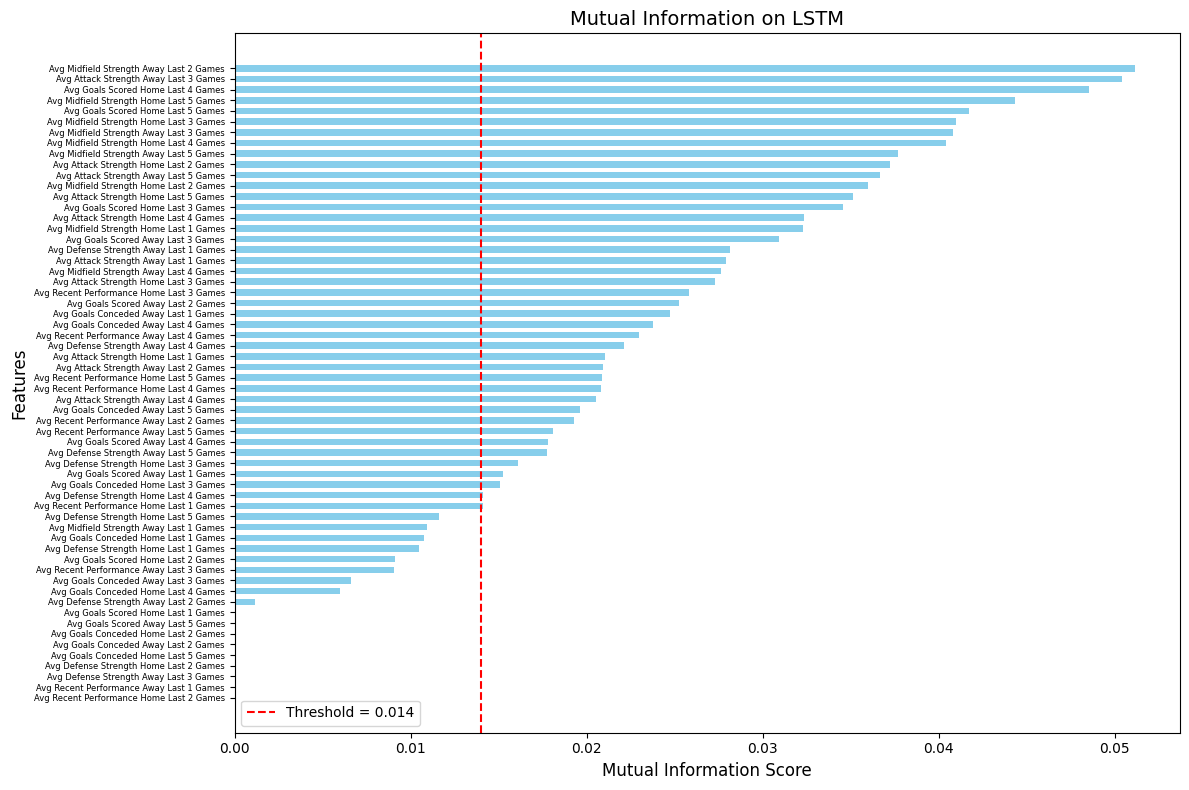


Selected Features based on Mutual Information Threshold: 42 / 60

Selected Features by RFE (RF):
['Avg Midfield Strength Away Last 2 Games', 'Avg Attack Strength Away Last 3 Games', 'Avg Goals Scored Home Last 4 Games', 'Avg Midfield Strength Home Last 5 Games', 'Avg Goals Scored Home Last 5 Games', 'Avg Midfield Strength Home Last 3 Games', 'Avg Midfield Strength Away Last 3 Games', 'Avg Midfield Strength Home Last 4 Games', 'Avg Midfield Strength Away Last 5 Games', 'Avg Attack Strength Home Last 2 Games', 'Avg Attack Strength Away Last 5 Games', 'Avg Midfield Strength Home Last 2 Games', 'Avg Attack Strength Home Last 5 Games', 'Avg Attack Strength Home Last 4 Games', 'Avg Midfield Strength Home Last 1 Games', 'Avg Goals Scored Away Last 3 Games', 'Avg Defense Strength Away Last 1 Games', 'Avg Attack Strength Away Last 1 Games', 'Avg Midfield Strength Away Last 4 Games', 'Avg Attack Strength Home Last 3 Games', 'Avg Goals Conceded Away Last 4 Games', 'Avg Defense Strength Away Last

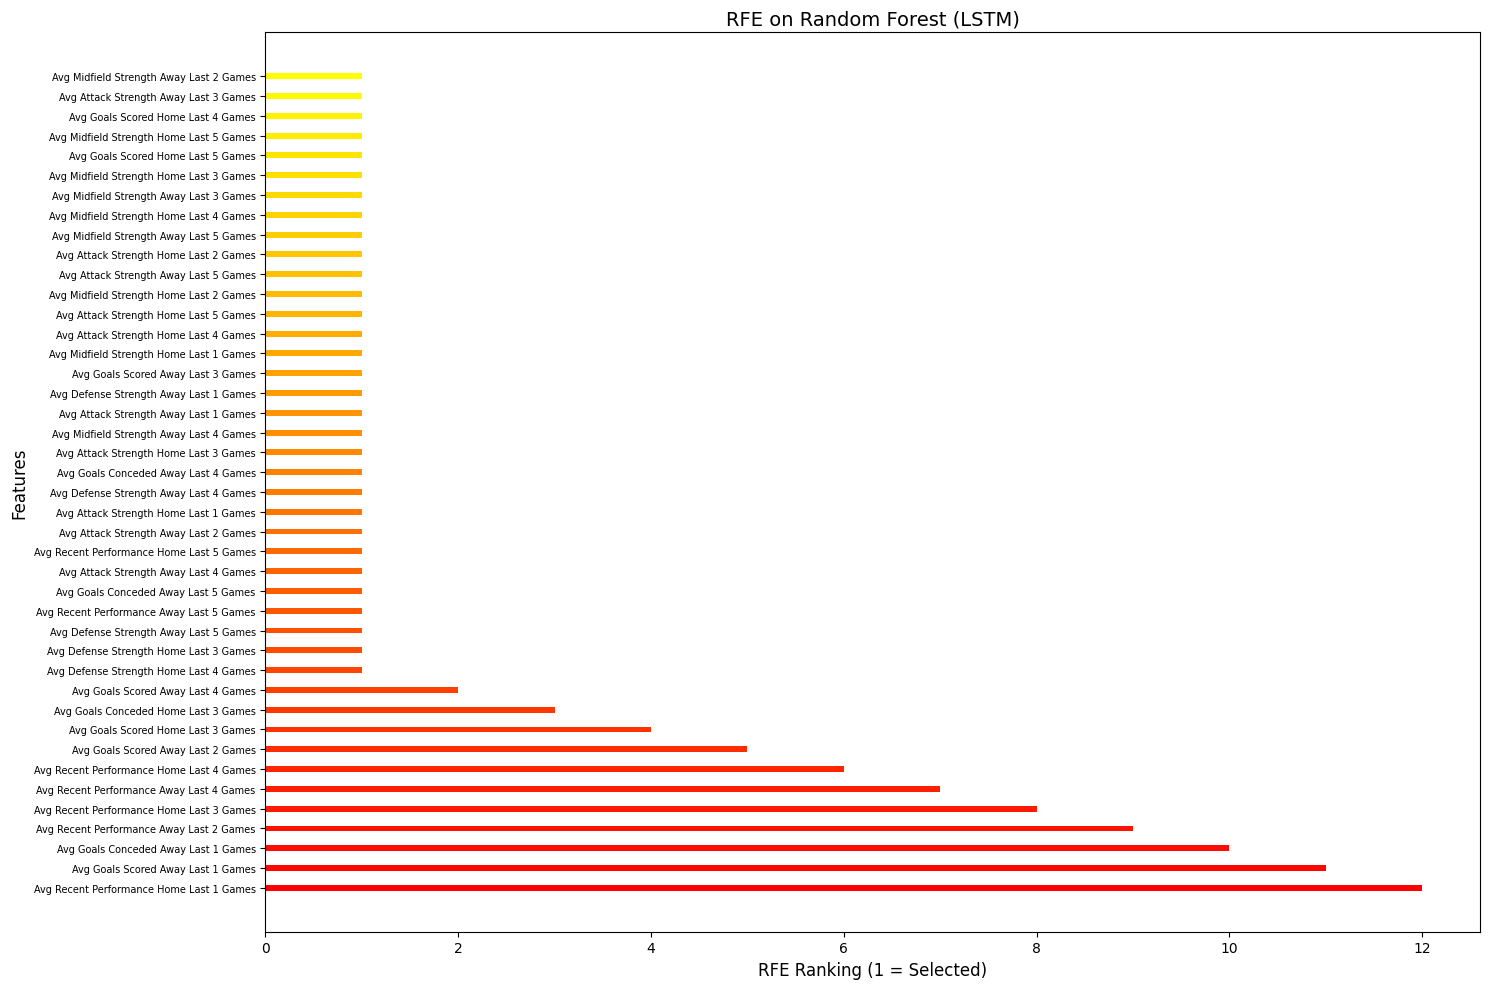

In [965]:
def lstm_feature_selection(df):
    # first applies mutual information and removes the redundant features
    def mutual_info(data, target, threshold=0.014):
        gain = mutual_info_regression(data, target)

        # dictionary of feature importance scores
        feature_names = list(data.columns)
        scores = {}
        for i in range(len(feature_names)):
            scores[feature_names[i]] = gain[i]

        # sort features by importance score in descending order
        sorted_features = sorted(scores.items(), key=lambda x: x[1], reverse=True)

        # plot a bar chart of feature importance scores
        fig, ax = plt.subplots(figsize=(12, 8))
        y_pos = np.arange(len(sorted_features))
        ax.barh(y_pos, [score for _, score in sorted_features], align="center", color="skyblue", height=0.6)
        ax.set_yticks(y_pos)
        ax.set_yticklabels([feature for feature, _ in sorted_features], fontsize=6)
        ax.invert_yaxis()
        ax.set_xlabel("Mutual Information Score", fontsize=12)
        ax.set_ylabel("Features", fontsize=12)
        ax.set_title("Mutual Information on LSTM", fontsize=14)
        plt.axvline(x=threshold, color="red", linestyle="--", label=f"Threshold = {threshold}")
        plt.legend()
        plt.tight_layout()
        plt.show()

        # filter features based on the threshold
        selected_features = [feature for feature, score in sorted_features if score >= threshold]
        print("\nSelected Features based on Mutual Information Threshold:", len(selected_features), "/", len(data.columns))

        return data[selected_features].copy()
    
    # perform tree based RFE on the remaining features
    def recursive_feature_elimination_RF(data, target):
        data = standardisation(data, terms=list(data.columns))

        # collect the feature names
        feature_names = list(data.columns)

        # perform RFE
        rfe = RFE(estimator=RandomForestClassifier(), n_features_to_select=number_of_components) # taken from PCA
        rfe.fit(data, target)

        # get feature rankings and selected features
        feature_ranking = rfe.ranking_
        selected_features = [feature for feature, rank in zip(feature_names, feature_ranking) if rank == 1]

        print("\nSelected Features by RFE (RF):")
        print(selected_features)

        # plot feature rankings
        plt.figure(figsize=(15, 10))
        sorted_features = sorted(zip(feature_names, feature_ranking), key=lambda x: x[1])
        sorted_names, sorted_ranks = zip(*sorted_features)

        # increase spacing between bars
        y_positions = np.arange(len(sorted_names)) * 2
        bar_height = 0.6

        # generate gradient colors from blue to green
        colors = [(1, 1 - alpha, 0) for alpha in np.linspace(0, 1, len(sorted_ranks))]

        # plot horizontal bar chart with gradient colors
        for ypos, rank, color in zip(y_positions, sorted_ranks, colors):
            plt.barh(ypos, rank, height=bar_height, color=color)

        plt.yticks(y_positions, sorted_names, fontsize=7)
        plt.xlabel("RFE Ranking (1 = Selected)", fontsize=12)
        plt.ylabel("Features", fontsize=12)
        plt.title("RFE on Random Forest (LSTM)", fontsize=14)

        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show() 

        return selected_features
    
    
    # organise dataset into X (training examples) and y (targets)
    featuresToDrop = ['Date', 'Match Outcome', 'Home Team']
    assert set(featuresToDrop).issubset(df.columns), "Some columns in featuresToDrop are missing in df"
    data = df.drop(featuresToDrop, axis=1)
    
    # use label encoding on the target data, keep it discrete
    target = df['Match Outcome']
    target = label_encoding(target, dataframe=False)
    
    reduced_data = mutual_info(data, target)
    
    return recursive_feature_elimination_RF(reduced_data, target)


    
lstm_features = lstm_feature_selection(df)

# Model Training and Testing

In [761]:
def chronological_split(df, train_ratio=0.8, chronological=False):
    df = df.sort_values(by='Date')
    df.drop(columns=['Date'], inplace=True)
    df.dropna(inplace=True)
    if chronological:
        train_size = int(len(df) * train_ratio)
        train_df = df[:train_size]
        test_df = df[train_size:]
    else:
        train_df, test_df = train_test_split(df, train_size=train_ratio, random_state=31, shuffle=True)
    return train_df, test_df

def encode_teams(df, encoding="one-hot"):
    if encoding == "one-hot":
        encoder = OneHotEncoder()
        encoded_teams = encoder.fit_transform(df[['Home Team']]).toarray()
        encoded_team_columns = encoder.get_feature_names_out(['Home Team'])
        
        encoded_df = pd.DataFrame(encoded_teams, columns=encoded_team_columns, index=df.index)
        df = pd.concat([df, encoded_df], axis=1)
        return df.drop(['Home Team'], axis=1)
    else:
        teams = df['Home Team'].unique()        
        encoder = LabelEncoder()
        encoder.fit(teams)
        
        df['Home Team'] = encoder.transform(df['Home Team'])
        
        return df
    
def standardize_features(df, features, scale_type='minmax'):
    if scale_type == 'minmax':
        scaler = MinMaxScaler()
    else: 
        scaler = StandardScaler()
    
    df[features] = scaler.fit_transform(df[features])
    return df

In [778]:
class RecencyModelTrainingNew:
    def __init__(self):
        pass

    
    # logistic regression model
    def train_with_iterations(self, X_train, y_train, X_test, y_test, iterations):
        metrics = {
            'train_accuracy': [], 'test_accuracy': [],
            'train_rmse': [], 'test_rmse': [],
            'train_precision': [], 'test_precision': [],
            'train_recall': [], 'test_recall': [],
            'train_f1': [], 'test_f1': []
        }

        for max_iter in iterations:
            model = LogisticRegression(
                multi_class='multinomial', solver='lbfgs', max_iter=max_iter,
                random_state=31
            )
            model.fit(X_train, y_train)

            train_predictions = model.predict(X_train)
            test_predictions = model.predict(X_test)

            self._compute_metrics(metrics, train_predictions, test_predictions, y_train, y_test)

        return metrics
    
    
    # logistic regression model with LASSO regression - regularisation strength C
    def train_with_iterations_l1(self, X_train, y_train, X_test, y_test, iterations, C=1.0):        
        metrics = {
            'train_accuracy': [], 'test_accuracy': [],
            'train_rmse': [], 'test_rmse': [],
            'train_precision': [], 'test_precision': [],
            'train_recall': [], 'test_recall': [],
            'train_f1': [], 'test_f1': []
        }
        
        feature_names = list(X_train.columns)
        selected_features = []

        for max_iter in iterations:
            model = LogisticRegression(
                penalty='l1', solver='liblinear', max_iter=max_iter, C=C, random_state=31
            )
            model.fit(X_train, y_train)

            train_predictions = model.predict(X_train)
            test_predictions = model.predict(X_test)

            self._compute_metrics(metrics, train_predictions, test_predictions, y_train, y_test)

            # get selected features (non-zero coefficients)
            non_zero_indices = np.where(model.coef_[0] != 0)[0]
            selected_features = [feature_names[i] for i in non_zero_indices if "Home Team" not in feature_names[i]]
            #print(f"Selected Features (max_iter={max_iter}): {selected_features}\n")

        print(f"Logistic Regression => LASSO Regularisation Selected Features (max_iter={iterations[-1]}): {selected_features}\n")

        return metrics
    
    
    # logistic regression model with Ridge regression - regularisation strength C
    def train_with_iterations_l2(self, X_train, y_train, X_test, y_test, iterations, C=1.0):        
        metrics = {
            'train_accuracy': [], 'test_accuracy': [],
            'train_rmse': [], 'test_rmse': [],
            'train_precision': [], 'test_precision': [],
            'train_recall': [], 'test_recall': [],
            'train_f1': [], 'test_f1': []
        }
        
        feature_names = list(X_train.columns)

        for max_iter in iterations:
            model = LogisticRegression(
                penalty='l2', solver='lbfgs', max_iter=max_iter, C=C, random_state=31
            )
            model.fit(X_train, y_train)

            train_predictions = model.predict(X_train)
            test_predictions = model.predict(X_test)

            self._compute_metrics(metrics, train_predictions, test_predictions, y_train, y_test)

        print(f"Logistic Regression => Ridge Regression Selected Features (max_iter={iterations[-1]}): Every feature. Just different weights.")
            
        return metrics
    
    
    #  logistic regression model with Elastic Net regularisation - regularisation strength C
    def train_with_iterations_l1_l2(self, X_train, y_train, X_test, y_test, iterations, C=1.0, l1_ratio=0.5):        
        metrics = {
            'train_accuracy': [], 'test_accuracy': [],
            'train_rmse': [], 'test_rmse': [],
            'train_precision': [], 'test_precision': [],
            'train_recall': [], 'test_recall': [],
            'train_f1': [], 'test_f1': []
        }
        
        feature_names = list(X_train.columns)
        selected_features = []

        for max_iter in iterations:
            model = LogisticRegression(
                penalty='elasticnet', solver='saga', max_iter=max_iter, C=C, 
                l1_ratio=l1_ratio, random_state=31
            )
            model.fit(X_train, y_train)

            train_predictions = model.predict(X_train)
            test_predictions = model.predict(X_test)

            self._compute_metrics(metrics, train_predictions, test_predictions, y_train, y_test)

            # Get selected features (non-zero coefficients)
            non_zero_indices = np.where(model.coef_[0] != 0)[0]
            selected_features = [feature_names[i] for i in non_zero_indices if "Home Team" not in feature_names[i]]
        
        print(f"Logistic Regression => Elastic Net Selected Features (max_iter={iterations[-1]}): {selected_features}\n")
        return metrics

    
    # k nearest neighbours model
    def train_and_evaluate_knn(self, X_train, y_train, X_test, y_test, neighbors_range):
        metrics = {
            'train_accuracy': [], 'test_accuracy': [],
            'train_rmse': [], 'test_rmse': [],
            'train_precision': [], 'test_precision': [],
            'train_recall': [], 'test_recall': [],
            'train_f1': [], 'test_f1': []
        }

        for n_neighbors in neighbors_range:
            knn = KNeighborsClassifier(n_neighbors=n_neighbors)
            knn.fit(X_train, y_train)

            train_predictions = knn.predict(X_train)
            test_predictions = knn.predict(X_test)

            self._compute_metrics(metrics, train_predictions, test_predictions, y_train, y_test)

        return metrics

    
    # support vector machine model
    def train_and_evaluate_svm(self, X_train, y_train, X_test, y_test):
        metrics = {
            'train_accuracy': [], 'test_accuracy': [],
            'train_rmse': [], 'test_rmse': [],
            'train_precision': [], 'test_precision': [],
            'train_recall': [], 'test_recall': [],
            'train_f1': [], 'test_f1': []
        }

        svm = SVC(kernel='linear', random_state=31)
        svm.fit(X_train, y_train)

        train_predictions = svm.predict(X_train)
        test_predictions = svm.predict(X_test)

        self._compute_metrics(metrics, train_predictions, test_predictions, y_train, y_test)

        return metrics
    
    
    # support vector model with l1 regression - regularisation strength C
    def train_and_evaluate_svm_l1(self, X_train, y_train, X_test, y_test, C=1.0):
        metrics = {
            'train_accuracy': [], 'test_accuracy': [],
            'train_rmse': [], 'test_rmse': [],
            'train_precision': [], 'test_precision': [],
            'train_recall': [], 'test_recall': [],
            'train_f1': [], 'test_f1': []
        }

        svm = LinearSVC(penalty='l1', dual=False, C=C, random_state=31)
        svm.fit(X_train, y_train)

        train_predictions = svm.predict(X_train)
        test_predictions = svm.predict(X_test)

        # print selected features
        feature_names = X_train.columns
        selected_features = [feature_names[i] for i in range(len(feature_names)) if svm.coef_[0, i] != 0 and "Home Team" not in feature_names[i]]
        original_feature_num = len([col for col in list(X_train.columns) if "Home Team" not in col])
        print(f"SVM => Selected Features with L1 Regularization: {len(selected_features)}/{original_feature_num}\n\n{selected_features}\n")

        self._compute_metrics(metrics, train_predictions, test_predictions, y_train, y_test)

        return metrics
    
    
    # support vector model with l2 regression - regularisation strength C
    def train_and_evaluate_svm_l2(self, X_train, y_train, X_test, y_test, C=1.0):
        metrics = {
            'train_accuracy': [], 'test_accuracy': [],
            'train_rmse': [], 'test_rmse': [],
            'train_precision': [], 'test_precision': [],
            'train_recall': [], 'test_recall': [],
            'train_f1': [], 'test_f1': []
        }

        # SVM with L2 regularization
        svm = LinearSVC(penalty='l2', dual=True, C=C, random_state=31)
        svm.fit(X_train, y_train)

        train_predictions = svm.predict(X_train)
        test_predictions = svm.predict(X_test)

        print("SVM => Selected Features with L2 Regularisation: Every feature. Just different weights.")
        
        self._compute_metrics(metrics, train_predictions, test_predictions, y_train, y_test)

        return metrics


    # long short-term memory model
    def train_and_evaluate_lstm(self, X_train, y_train, X_test, y_test, epochs=10):
        metrics = {
            'train_accuracy': [], 'test_accuracy': [],
            'train_rmse': [], 'test_rmse': [],
            'train_precision': [], 'test_precision': [],
            'train_recall': [], 'test_recall': [],
            'train_f1': [], 'test_f1': []
        }

        # one-hot encode the target labels for multi-class classification
        # since target variable is int (0, 1, 2), we use to_categorical to one-hot encode it
        y_train_one_hot = to_categorical(y_train, num_classes=3)
        y_test_one_hot = to_categorical(y_test, num_classes=3)

        # reshape data for LSTM [samples, time steps, features]
        X_train = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
        X_test = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))

        # define the LSTM model
        lstm_model = Sequential([
            LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
            LSTM(64, return_sequences=False),
            Dense(3, activation='softmax')  # For multi-class classification (3 classes)
        ])
        
        # compile the model with categorical crossentropy for multi-class classification
        # then train and predict probabilities.
        lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        lstm_model.fit(X_train, y_train_one_hot, epochs=epochs, batch_size=32, verbose=1)

        train_predictions = lstm_model.predict(X_train)
        test_predictions = lstm_model.predict(X_test)
        
        train_predictions = train_predictions.argmax(axis=1) # convert probabilities to class predictions (0, 1, or 2)
        test_predictions = test_predictions.argmax(axis=1) # select the class with the highest probability

        self._compute_metrics(metrics, train_predictions, test_predictions, y_train, y_test)

        return metrics
    
    
    # long short-term model with l1 regularisation
    def train_and_evaluate_lstm_l1(self, X_train, y_train, X_test, y_test, epochs=10, l1_penalty=0.1):
        metrics = {
            'train_accuracy': [], 'test_accuracy': [],
            'train_rmse': [], 'test_rmse': [],
            'train_precision': [], 'test_precision': [],
            'train_recall': [], 'test_recall': [],
            'train_f1': [], 'test_f1': []
        }
        
        feature_names = X_train.columns

        # one-hot encode the target labels for multi-class classification
        y_train_one_hot = to_categorical(y_train, num_classes=3)
        y_test_one_hot = to_categorical(y_test, num_classes=3)

        # reshape data for LSTM [samples, time steps, features]
        X_train = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
        X_test = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))

        # define the LSTM model with L1 regularisation
        lstm_model = Sequential([
            LSTM(
                64, 
                input_shape=(X_train.shape[1], X_train.shape[2]), 
                return_sequences=True, 
                kernel_regularizer=regularizers.l1(l1_penalty)
            ),
            LSTM(
                64, 
                return_sequences=False, 
                kernel_regularizer=regularizers.l1(l1_penalty)
            ),
            Dense(3, activation='softmax')  # for multi-class classification (3 classes)
        ])
        
        # compile the model and predict
        lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        lstm_model.fit(X_train, y_train_one_hot, epochs=epochs, batch_size=32, verbose=1)

        train_predictions = lstm_model.predict(X_train).argmax(axis=1)
        test_predictions = lstm_model.predict(X_test).argmax(axis=1)

        # print selected features based on non-zero weights from the first LSTM layer
        lstm_weights = lstm_model.layers[0].get_weights()[0]  # get weights of the first LSTM layer
        selected_features = [feature_names[i] for i in range(X_train.shape[2]) if np.any(np.abs(lstm_weights[:, i]) > 1e-4) and "Home Team" not in feature_names[i]]
        original_feature_count = len([f for f in feature_names if "Home Team" not in f])

        print(f"LSTM => Selected Features with L1 Regularisation: {len(selected_features)}/{original_feature_count}\n\n{selected_features}\n")
        
        self._compute_metrics(metrics, train_predictions, test_predictions, y_train, y_test)

        return metrics

    
    # long short-term model with l1 regularisation
    def train_and_evaluate_lstm_l2(self, X_train, y_train, X_test, y_test, epochs=10, l2_penalty=0.1):
        metrics = {
            'train_accuracy': [], 'test_accuracy': [],
            'train_rmse': [], 'test_rmse': [],
            'train_precision': [], 'test_precision': [],
            'train_recall': [], 'test_recall': [],
            'train_f1': [], 'test_f1': []
        }

        # one-hot encode the target labels for multi-class classification
        y_train_one_hot = to_categorical(y_train, num_classes=3)
        y_test_one_hot = to_categorical(y_test, num_classes=3)

        # reshape data for LSTM [samples, time steps, features]
        X_train = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
        X_test = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))

        # define the LSTM model with L2 regularisation
        lstm_model = Sequential([
            LSTM(
                64, 
                input_shape=(X_train.shape[1], X_train.shape[2]), 
                return_sequences=True, 
                kernel_regularizer=regularizers.l2(l2_penalty)
            ),
            LSTM(
                64, 
                return_sequences=False, 
                kernel_regularizer=regularizers.l2(l2_penalty)
            ),
            Dense(3, activation='softmax')  # For multi-class classification (3 classes)
        ])

        # compile the model and predict
        lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        lstm_model.fit(X_train, y_train_one_hot, epochs=epochs, batch_size=32, verbose=1)

        train_predictions = lstm_model.predict(X_train).argmax(axis=1)
        test_predictions = lstm_model.predict(X_test).argmax(axis=1)

        # compute metrics for multi-class classification
        self._compute_metrics(metrics, train_predictions, test_predictions, y_train, y_test)

        return metrics
    
    
    # long short-term model with l1 and l2 regularisation
    def train_and_evaluate_lstm_l1_l2(self, X_train, y_train, X_test, y_test, epochs=10, l1_penalty=0.1, l2_penalty=0.1):
        metrics = {
            'train_accuracy': [], 'test_accuracy': [],
            'train_rmse': [], 'test_rmse': [],
            'train_precision': [], 'test_precision': [],
            'train_recall': [], 'test_recall': [],
            'train_f1': [], 'test_f1': []
        }

        # one-hot encode the target labels for multi-class classification
        y_train_one_hot = to_categorical(y_train, num_classes=3)
        y_test_one_hot = to_categorical(y_test, num_classes=3)

        # reshape data for LSTM [samples, time steps, features]
        X_train = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
        X_test = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))

        # define the LSTM model with both L1 and L2 regularisation
        lstm_model = Sequential([
            LSTM(
                64, 
                input_shape=(X_train.shape[1], X_train.shape[2]), 
                return_sequences=True, 
                kernel_regularizer=regularizers.l1_l2(l1=l1_penalty, l2=l2_penalty)
            ),
            LSTM(
                64, 
                return_sequences=False, 
                kernel_regularizer=regularizers.l1_l2(l1=l1_penalty, l2=l2_penalty)
            ),
            Dense(3, activation='softmax')  # for multi-class classification (3 classes)
        ])

        # compile the model and predict
        lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        lstm_model.fit(X_train, y_train_one_hot, epochs=epochs, batch_size=32, verbose=1)

        train_predictions = lstm_model.predict(X_train).argmax(axis=1)
        test_predictions = lstm_model.predict(X_test).argmax(axis=1)

        # compute metrics for multi-class classification
        self._compute_metrics(metrics, train_predictions, test_predictions, y_train, y_test)

        return metrics
    
    
    # long short-term model with drop out regularisation
    def train_and_evaluate_lstm_dropout(self, X_train, y_train, X_test, y_test, epochs=10, dropout_rate=0.2):
        metrics = {
            'train_accuracy': [], 'test_accuracy': [],
            'train_rmse': [], 'test_rmse': [],
            'train_precision': [], 'test_precision': [],
            'train_recall': [], 'test_recall': [],
            'train_f1': [], 'test_f1': []
        }

        # one-hot encode the target labels for multi-class classification
        y_train_one_hot = to_categorical(y_train, num_classes=3)
        y_test_one_hot = to_categorical(y_test, num_classes=3)

        # reshape data for LSTM [samples, time steps, features]
        X_train = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
        X_test = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))

        # define the LSTM model with Dropout regularisation
        lstm_model = Sequential([
            LSTM(
                64, 
                input_shape=(X_train.shape[1], X_train.shape[2]), 
                return_sequences=True
            ),
            Dropout(dropout_rate),  # add dropout after the first LSTM layer
            LSTM(
                64, 
                return_sequences=False
            ),
            Dropout(dropout_rate),  # add dropout after the second LSTM layer
            Dense(3, activation='softmax')  # For multi-class classification (3 classes)
        ])

        # compile the model and predict
        lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        lstm_model.fit(X_train, y_train_one_hot, epochs=epochs, batch_size=32, verbose=1)

        train_predictions = lstm_model.predict(X_train).argmax(axis=1)
        test_predictions = lstm_model.predict(X_test).argmax(axis=1)

        # compute metrics for multi-class classification
        self._compute_metrics(metrics, train_predictions, test_predictions, y_train, y_test)

        return metrics

    
    # calculates metrics for a trained model
    def _compute_metrics(self, metrics, train_predictions, test_predictions, y_train, y_test):
        train_accuracy = accuracy_score(y_train, train_predictions)
        test_accuracy = accuracy_score(y_test, test_predictions)

        metrics['train_accuracy'].append(train_accuracy)
        metrics['test_accuracy'].append(test_accuracy)

        metrics['train_rmse'].append(np.sqrt(np.mean((y_train - train_predictions) ** 2)))
        metrics['test_rmse'].append(np.sqrt(np.mean((y_test - test_predictions) ** 2)))

        train_precision, train_recall, train_f1, _ = precision_recall_fscore_support(
            y_train, train_predictions, average='weighted'
        )
        test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(
            y_test, test_predictions, average='weighted'
        )

        metrics['train_precision'].append(train_precision)
        metrics['test_precision'].append(test_precision)
        metrics['train_recall'].append(train_recall)
        metrics['test_recall'].append(test_recall)
        metrics['train_f1'].append(train_f1)
        metrics['test_f1'].append(test_f1)

        
    def plot_metrics(self, metrics, model_name, iterations=None, neighbors_range=None):
        metric_keys = list(metrics.keys())
        n_metrics = len(metric_keys)

        plt.figure(figsize=(15, 10))
        print(model_name, "\n\n")
        for i, key in enumerate(metric_keys, 1):
            plt.subplot((n_metrics + 1) // 2, 2, i)

            # Print the metric data for debugging
#             print(f"Plotting Metric: {key}")
#             print(f"Metric Data: {metrics[key]}")  # Print the actual metrics data for inspection
            
            if iterations is not None:
#                 print(f"Iterations: {iterations}")
                # Ensure that iterations and metrics match in length
                if len(metrics[key]) != len(iterations):
                    print(f"Warning: Length mismatch between iterations and {key} metric")
                plt.plot(iterations, metrics[key], label=key, marker='o')
                x_vals = iterations
            elif neighbors_range is not None:
#                 print(f"Neighbors Range: {neighbors_range}")
                # Ensure that neighbors_range and metrics match in length
                if len(metrics[key]) != len(neighbors_range):
                    print(f"Warning: Length mismatch between neighbors_range and {key} metric")
                plt.plot(neighbors_range, metrics[key], label=key, marker='o')
                x_vals = neighbors_range
            else:
                plt.plot(metrics[key], label=key, marker='o')
                x_vals = range(len(metrics[key]))  # Default x-values if neither is provided

            # Check if there are multiple values to plot
            if len(x_vals) > 1:
                for x, y in zip(x_vals, metrics[key]):
                    plt.text(x, y, f'{y:.2f}', fontsize=8, ha='center', va='bottom')
            else:
                print(f"Warning: Only one data point for {key}. This may indicate an issue with data collection.")

            plt.xlabel('Iterations' if iterations is not None else 'Number of Neighbors')
            plt.ylabel(f'{key}')
            plt.title(f'{model_name} - {key} over Iterations' if iterations is not None else f'{model_name} - {key} over Neighbors')
            plt.grid()

        plt.tight_layout()
        plt.show()

        
    def save_model(self, filename):
        joblib.dump(self.model, filename)

        
    def load_model(self, filename):
        self.model = joblib.load(filename)


## Recency Model Training

The first model training will be focused solely on Recency. Features based on past games will be used to train the model.

In [784]:
print('Preprocessing Data...')
first_df = encode_teams(df)
numerical_features = [col for col in first_df.columns if 'Avg' in col]
first_df = standardize_features(first_df, numerical_features)

first_train_df, first_test_df = chronological_split(first_df)

first_X_train, first_y_train = first_train_df.drop('Match Outcome', axis=1), first_train_df['Match Outcome']
first_X_test, first_y_test = first_test_df.drop('Match Outcome', axis=1), first_test_df['Match Outcome']

Preprocessing Data...


In [785]:
# Model Training
print('Starting Training...')
trainer = RecencyModelTrainingNew()

iterations = np.arange(0, 200, 10)
neighbors_range = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51]

metrics_logistic = trainer.train_with_iterations(first_X_train, first_y_train, first_X_test, first_y_test, iterations)
metrics_knn = trainer.train_and_evaluate_knn(first_X_train, first_y_train, first_X_test, first_y_test, neighbors_range)
metrics_svm = trainer.train_and_evaluate_svm(first_X_train, first_y_train, first_X_test, first_y_test)
metrics_lstm = trainer.train_and_evaluate_lstm(first_X_train, first_y_train, first_X_test, first_y_test, epochs=10)

Starting Training...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: Und

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: Conve

Epoch 1/10


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


67/67 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.4544 - loss: 1.0637
Epoch 2/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5326 - loss: 0.9759
Epoch 3/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5438 - loss: 0.9674
Epoch 4/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5321 - loss: 0.9653
Epoch 5/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5485 - loss: 0.9403
Epoch 6/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5607 - loss: 0.9329
Epoch 7/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5377 - loss: 0.9490
Epoch 8/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5634 - loss: 0.9290
Epoch 9/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5808 - loss: 0.9213
Epoch 10/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5745 - loss: 0.9253
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_pr

Logistic Regression 




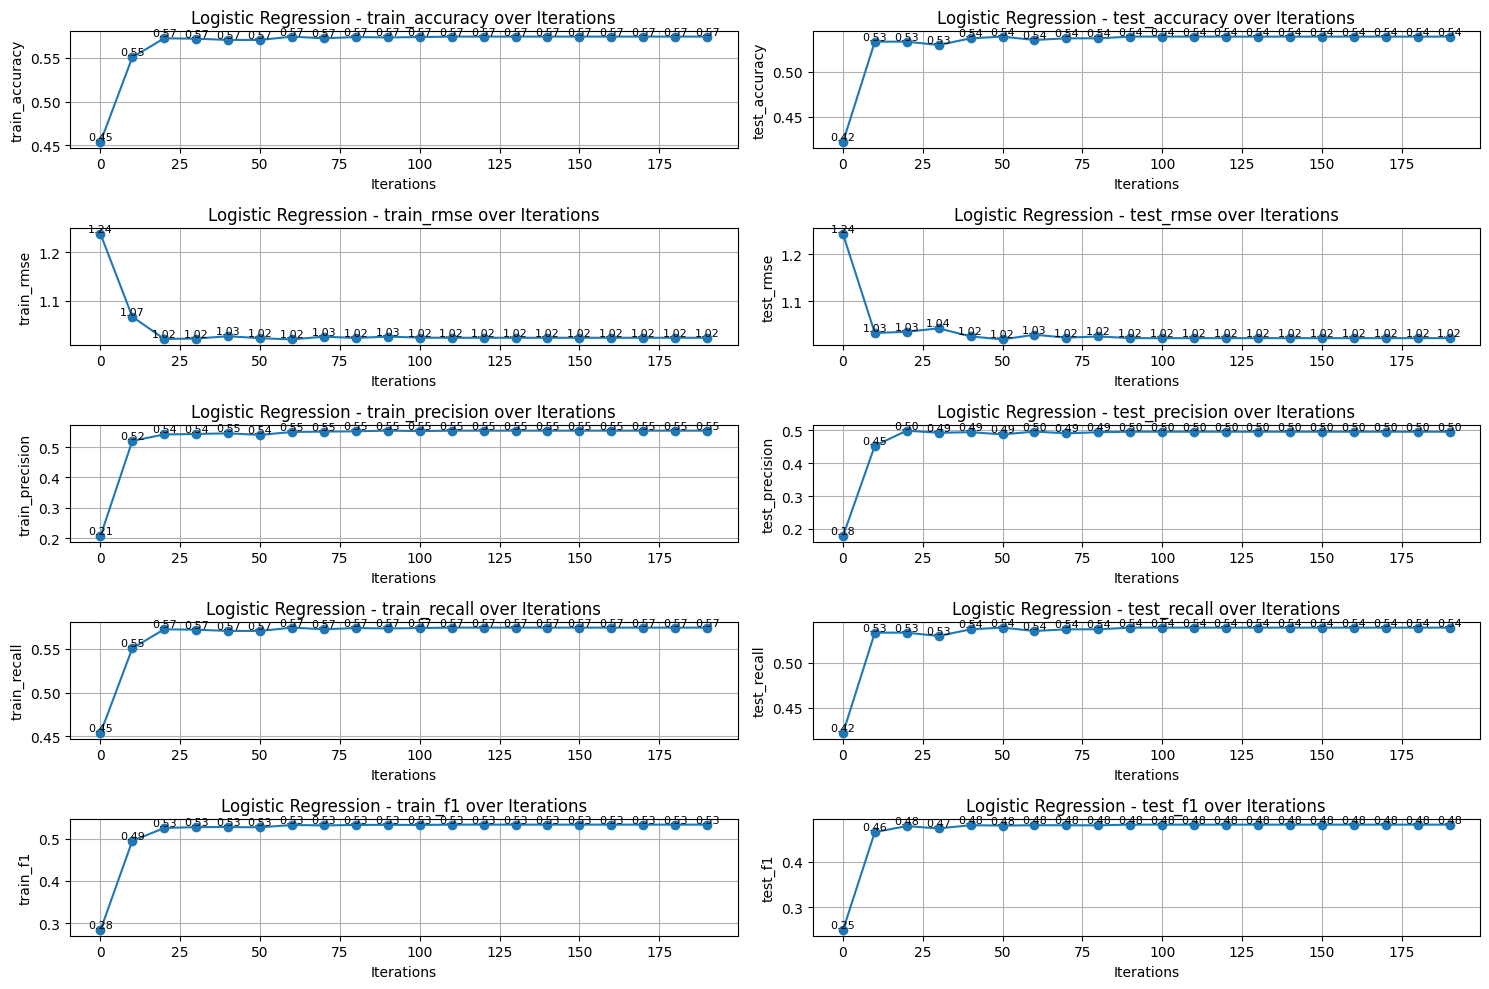

KNN 




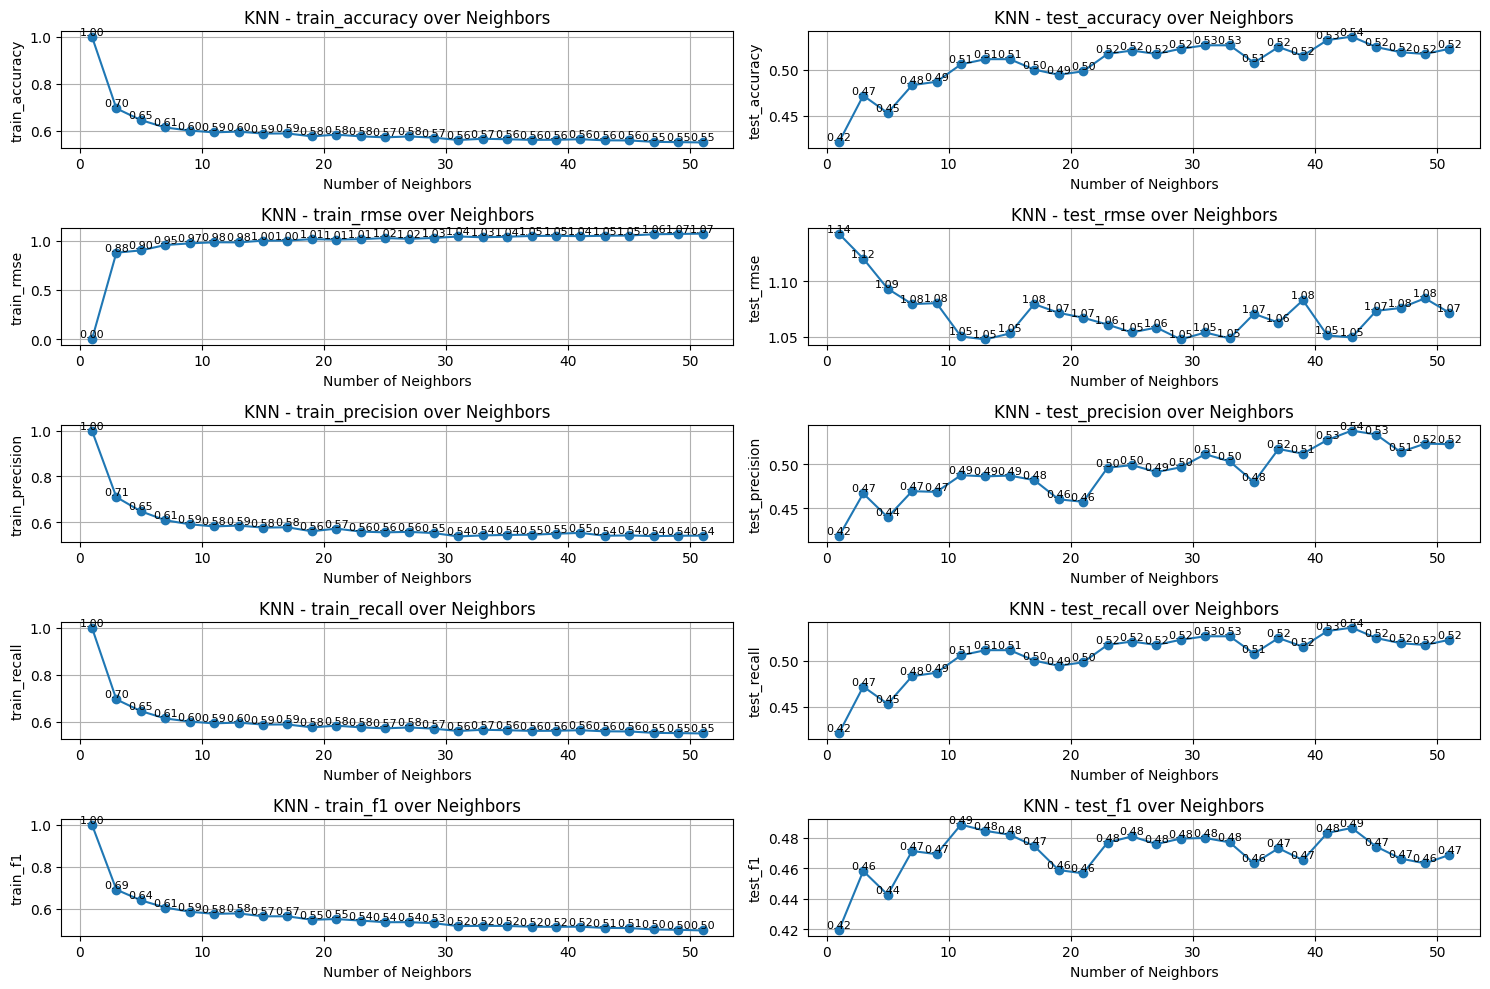

SVM 




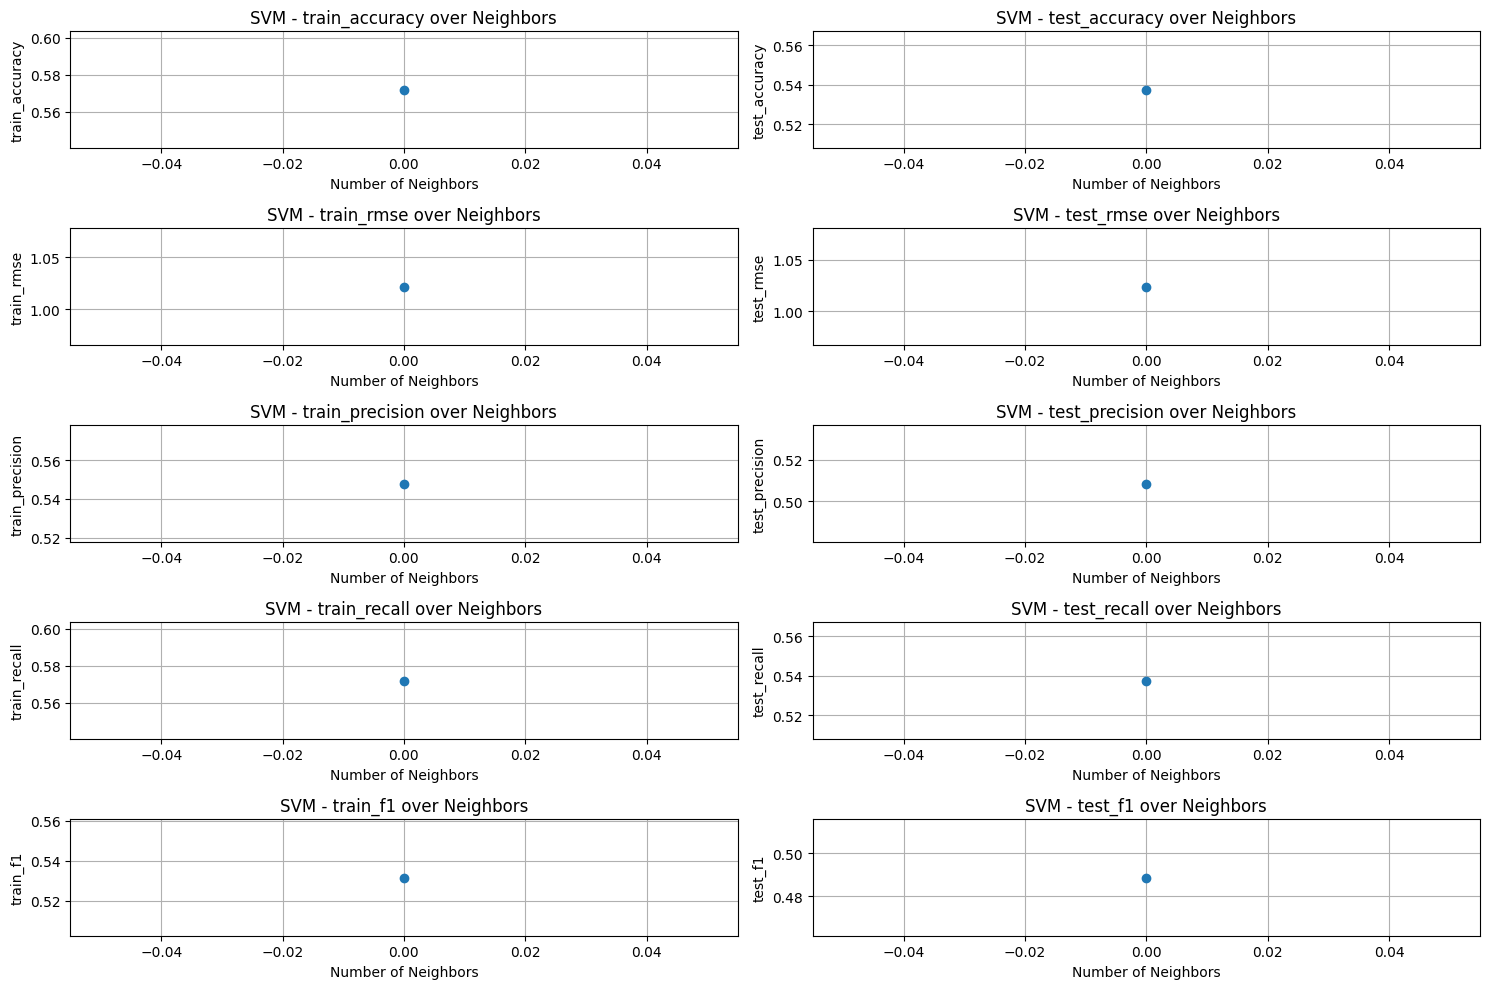

LSTM 




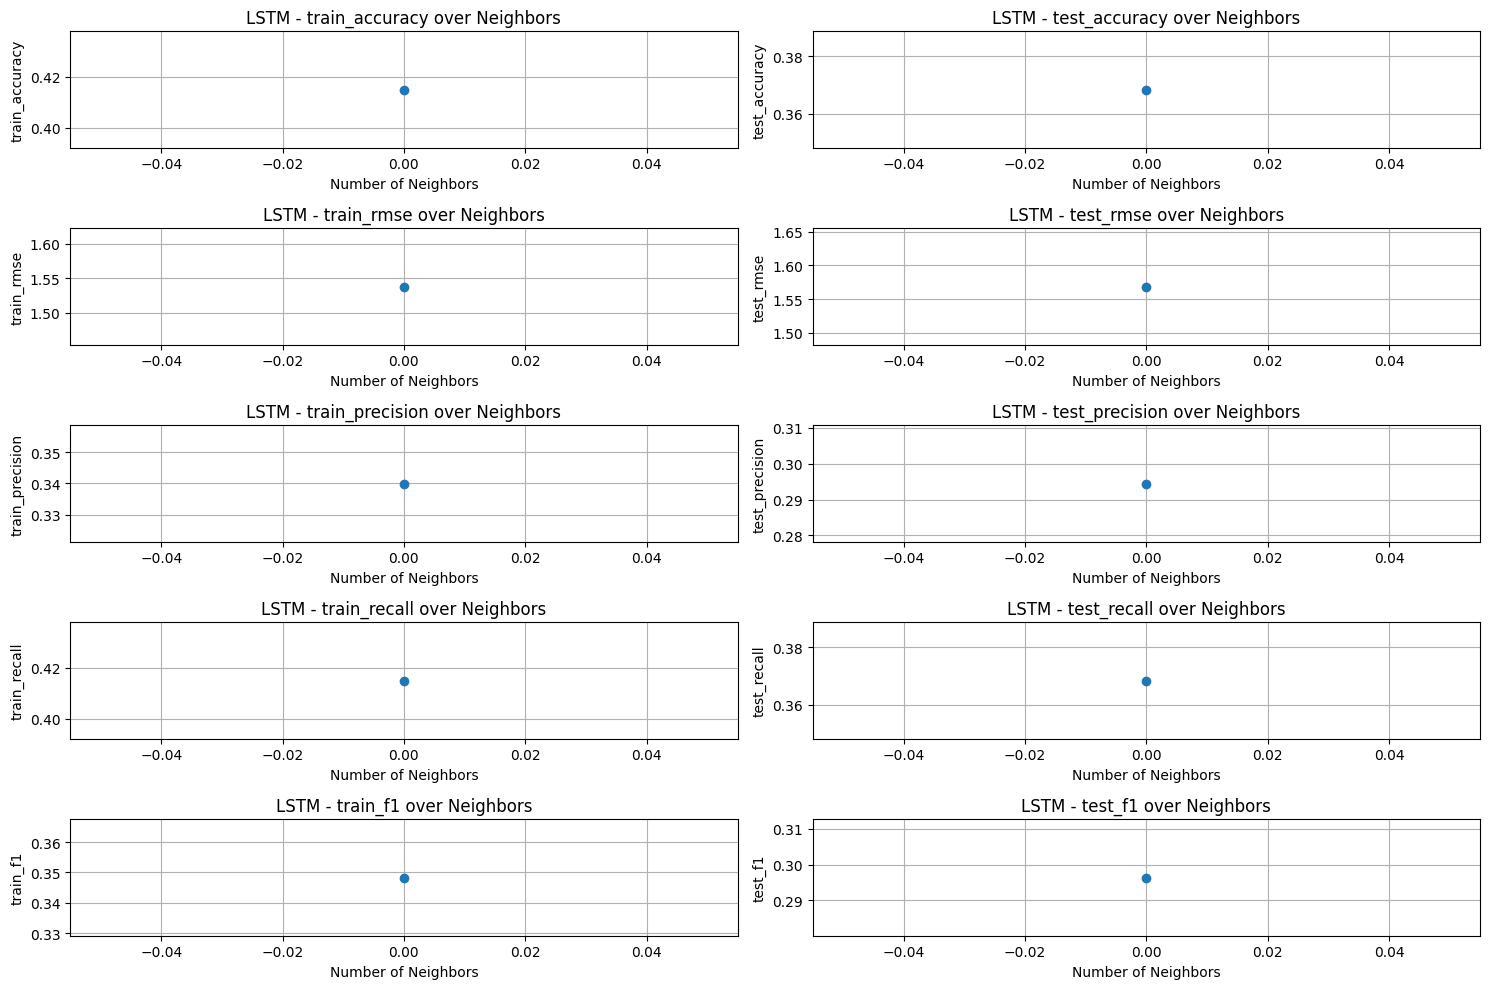

In [786]:
# Plotting Metrics for all Models
trainer.plot_metrics(metrics_logistic, "Logistic Regression", iterations=iterations)
trainer.plot_metrics(metrics_knn, "KNN", neighbors_range=neighbors_range)
trainer.plot_metrics(metrics_svm, "SVM")
trainer.plot_metrics(metrics_lstm, "LSTM")

## Feature Selection Model Training

These models will be trained with datasets created from our previous feature selection methods. Each of the four models used a specific selection method that corresponded well with the model type. 

In [766]:
missing_features = ['Home Team', 'Match Outcome', 'Date'] # removed during feature selection

logistic_df = df[missing_features + logistic_features]
knn_df = df[missing_features + knn_features]
svm_df = df[missing_features + svm_features]
lstm_df = df[missing_features + lstm_features]

In [767]:
print('Preprocessing Data...')

# encoding and standardising for each of the four feature sets
logistic_df = encode_teams(logistic_df)
knn_df = encode_teams(knn_df)
svm_df = encode_teams(svm_df)
lstm_df = encode_teams(lstm_df)

logistic_df = standardize_features(logistic_df, logistic_features)
knn_df = standardize_features(knn_df, knn_features)
svm_df = standardize_features(svm_df, svm_features)
lstm_df = standardize_features(lstm_df, lstm_features)


# split the data into X (data) and y (target) for training and testing
logistic_train_df, logistic_test_df = chronological_split(logistic_df)
knn_train_df, knn_test_df = chronological_split(knn_df)
svm_train_df, svm_test_df = chronological_split(svm_df)
lstm_train_df, lstm_test_df = chronological_split(lstm_df)

logistic_X_train, logistic_y_train = logistic_train_df.drop('Match Outcome', axis=1), logistic_train_df['Match Outcome']
logistic_X_test, logistic_y_test = logistic_test_df.drop('Match Outcome', axis=1), logistic_test_df['Match Outcome']

knn_X_train, knn_y_train = knn_train_df.drop('Match Outcome', axis=1), knn_train_df['Match Outcome']
knn_X_test, knn_y_test = knn_test_df.drop('Match Outcome', axis=1), knn_test_df['Match Outcome']

svm_X_train, svm_y_train = svm_train_df.drop('Match Outcome', axis=1), svm_train_df['Match Outcome']
svm_X_test, svm_y_test = svm_test_df.drop('Match Outcome', axis=1), svm_test_df['Match Outcome']

lstm_X_train, lstm_y_train = lstm_train_df.drop('Match Outcome', axis=1), lstm_train_df['Match Outcome']
lstm_X_test, lstm_y_test = lstm_test_df.drop('Match Outcome', axis=1), lstm_test_df['Match Outcome']

Preprocessing Data...


In [779]:
# Model Training
print('Starting Training...')
trainer = RecencyModelTrainingNew()

iterations = np.arange(0, 200, 10)
neighbors_range = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51]

metrics_logistic2 = trainer.train_with_iterations(logistic_X_train, logistic_y_train, logistic_X_test, logistic_y_test, iterations)
metrics_knn2 = trainer.train_and_evaluate_knn(knn_X_train, knn_y_train, knn_X_test, knn_y_test, neighbors_range)
metrics_svm2 = trainer.train_and_evaluate_svm(svm_X_train, svm_y_train, svm_X_test, svm_y_test)
metrics_lstm2 = trainer.train_and_evaluate_lstm(lstm_X_train, lstm_y_train, lstm_X_test, lstm_y_test, epochs=10)

Starting Training...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: Und

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Library/Frameworks/Pytho

Epoch 1/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.4252 - loss: 1.0758
Epoch 2/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5077 - loss: 0.9927
Epoch 3/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5521 - loss: 0.9548
Epoch 4/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5306 - loss: 0.9663
Epoch 5/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5523 - loss: 0.9453
Epoch 6/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5553 - loss: 0.9443
Epoch 7/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5505 - loss: 0.9366
Epoch 8/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5664 - loss: 0.9323
Epoch 9/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5545 - loss: 0.9321
Epoch 10/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5587 - loss: 0.9464
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_pr

Logistic Regression (Feature Selection) 




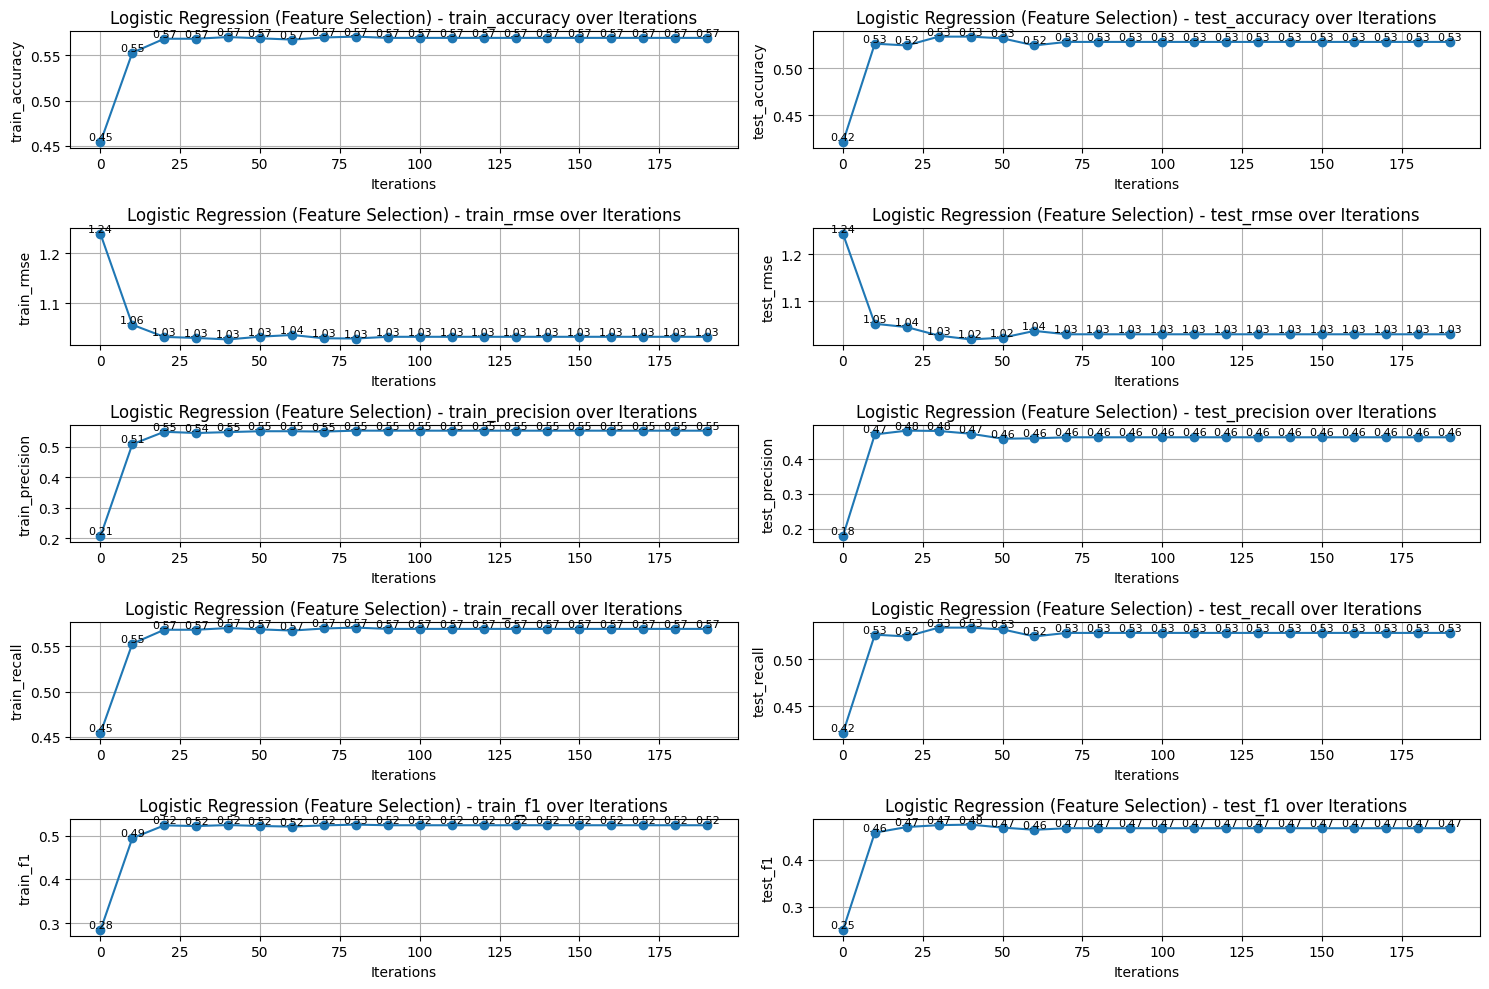

KNN (Feature Selection) 




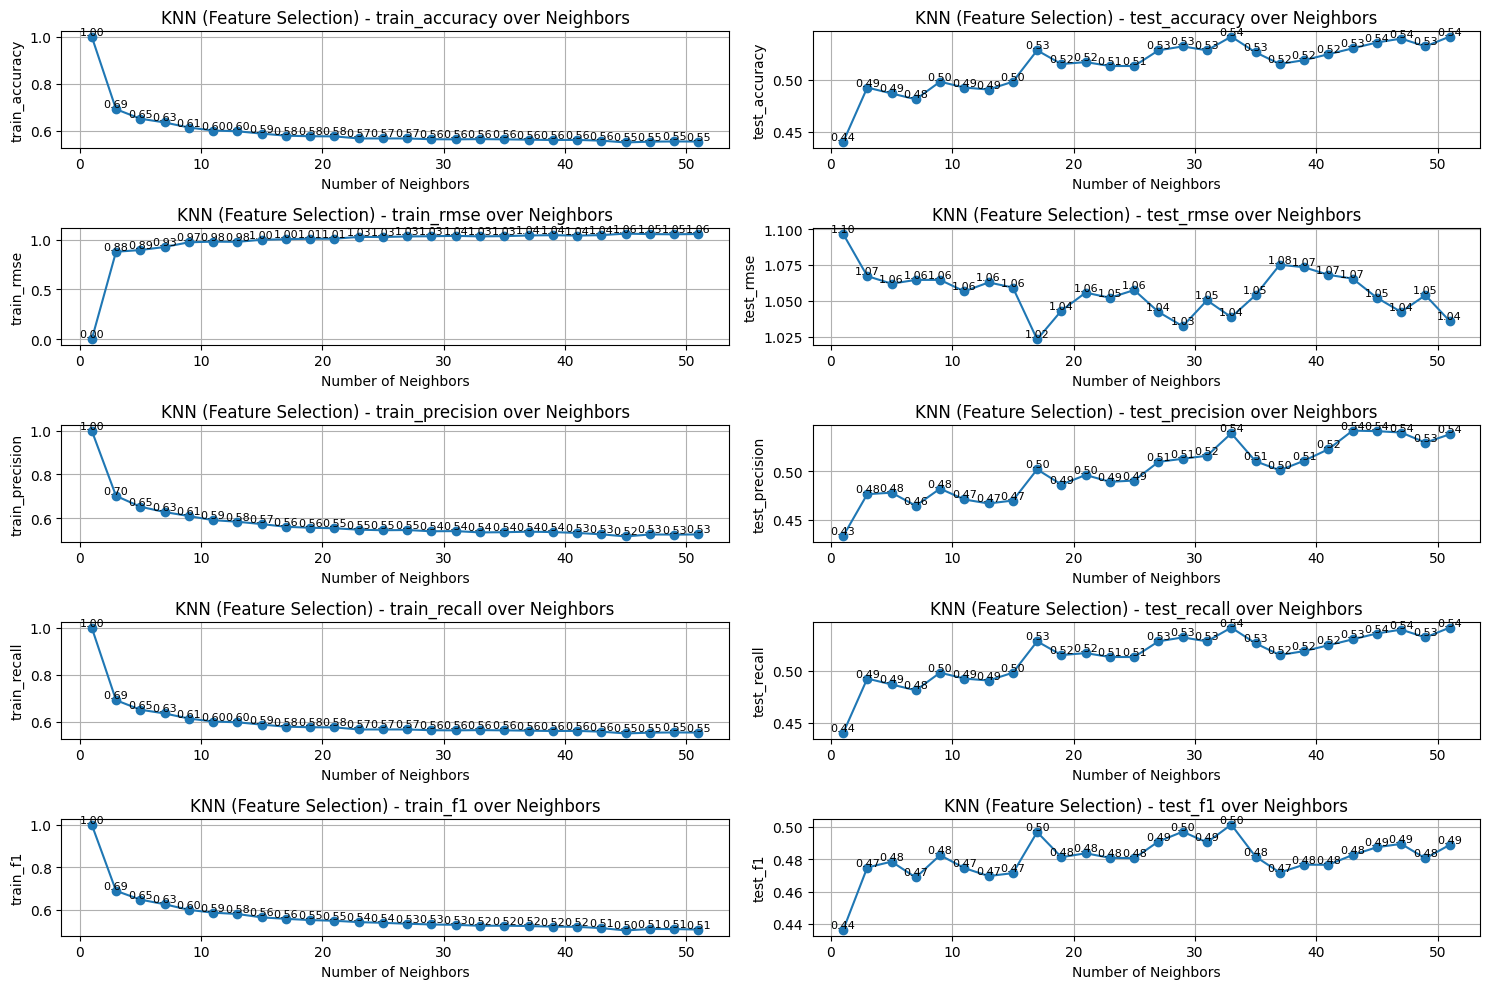

SVM (Feature Selection) 




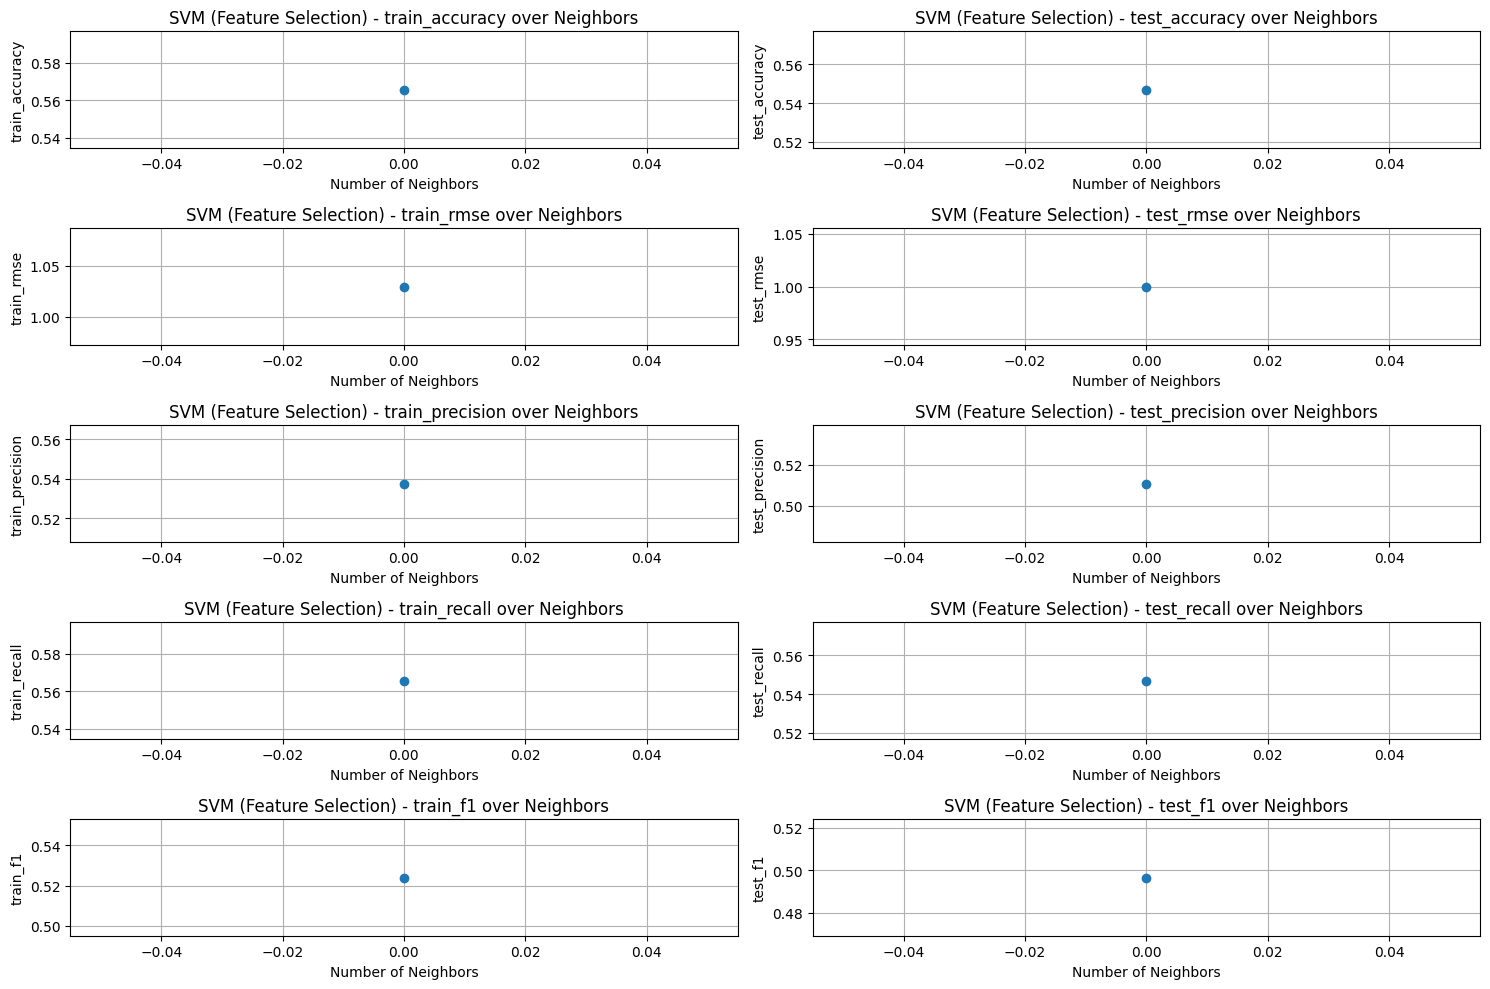

LSTM (Feature Selection) 




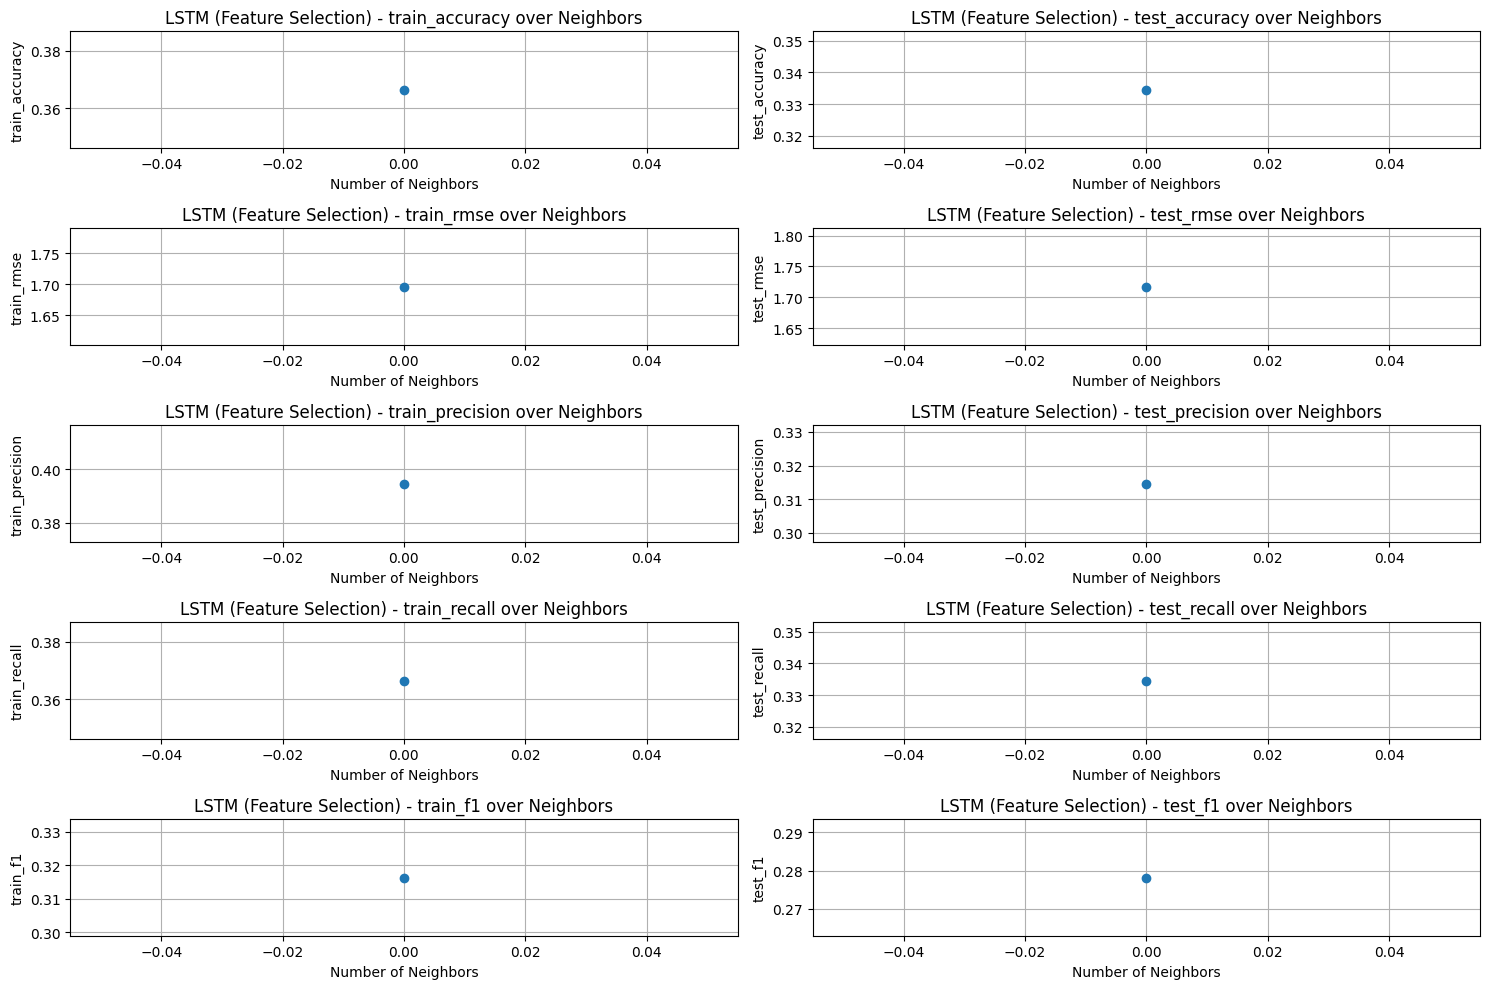

In [780]:
# Plotting Metrics for all Models
trainer.plot_metrics(metrics_logistic2, "Logistic Regression (Feature Selection)", iterations=iterations)
trainer.plot_metrics(metrics_knn2, "KNN (Feature Selection)", neighbors_range=neighbors_range)
trainer.plot_metrics(metrics_svm2, "SVM (Feature Selection)")
trainer.plot_metrics(metrics_lstm2, "LSTM (Feature Selection)")

## Embedded Feature Selection Model Training

In the following selection, we will focus on embedded feature selection methods. For the Logistic Regression model, we will use the entire recency data set and try out LASSO regression, Ridge regression, and Elastic Net regularisation to see which technique fairs best.

The KNN model does not support any traditional regularisation techniques as it is non-parametric. It is possible to indirectly apply regularisation-like effects to the model. However, we will not be looking at these indirect methods. 

SVM models, on the other hand, do support traditional regularisation techniques. We will implement L1 and L2 regression. Elastic Net regularisation is not very commonly used and will not be tested.

Similarly, LSTM models allow L1 and L2 regression techniques that control the weights of the model. Furthermore, we will implemented drop out regularisation - where a fraction of the neurons are randomly removed to prevent highly correlated units.  

In [781]:
print('Preprocessing Data...')


full_df = encode_teams(df)
full_df = standardize_features(full_df, numerical_features)

full_train_df, full_test_df = chronological_split(full_df)

full_X_train, full_y_train = full_train_df.drop('Match Outcome', axis=1), full_train_df['Match Outcome']
full_X_test, full_y_test = full_test_df.drop('Match Outcome', axis=1), full_test_df['Match Outcome']

Preprocessing Data...


In [782]:
# Model Training
print('Starting Training...')
trainer = RecencyModelTrainingNew()

iterations = np.arange(0, 200, 10)
neighbors_range = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51]

metrics_logistic_l1 = trainer.train_with_iterations_l1(full_X_train, full_y_train, full_X_test, full_y_test, iterations)
metrics_logistic_l2 = trainer.train_with_iterations_l2(full_X_train, full_y_train, full_X_test, full_y_test, iterations)
metrics_logistic_l1_l2 = trainer.train_with_iterations_l1_l2(full_X_train, full_y_train, full_X_test, full_y_test, iterations, l1_ratio=0.5)

metrics_svm_l1 = trainer.train_and_evaluate_svm_l1(full_X_train, full_y_train, full_X_test, full_y_test)
metrics_svm_l2 = trainer.train_and_evaluate_svm_l2(full_X_train, full_y_train, full_X_test, full_y_test)

metrics_lstm_l1 = trainer.train_and_evaluate_lstm_l1(full_X_train, full_y_train, full_X_test, full_y_test, epochs=10)
metrics_lstm_l2 = trainer.train_and_evaluate_lstm_l2(full_X_train, full_y_train, full_X_test, full_y_test, epochs=10)
metrics_lstm_l1_l2 = trainer.train_and_evaluate_lstm_l1_l2(full_X_train, full_y_train, full_X_test, full_y_test, epochs=10)
metrics_lstm_dropout = trainer.train_and_evaluate_lstm_dropout(full_X_train, full_y_train, full_X_test, full_y_test, epochs=10)

Starting Training...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packag

Logistic Regression => LASSO Regularisation Selected Features (max_iter=190): ['Avg Goals Scored Home Last 1 Games', 'Avg Goals Scored Away Last 1 Games', 'Avg Goals Scored Home Last 2 Games', 'Avg Goals Scored Home Last 3 Games', 'Avg Goals Scored Away Last 3 Games', 'Avg Goals Scored Home Last 5 Games', 'Avg Goals Conceded Away Last 1 Games', 'Avg Goals Conceded Home Last 4 Games', 'Avg Goals Conceded Away Last 4 Games', 'Avg Goals Conceded Away Last 5 Games', 'Avg Attack Strength Away Last 1 Games', 'Avg Attack Strength Home Last 4 Games', 'Avg Attack Strength Home Last 5 Games', 'Avg Attack Strength Away Last 5 Games', 'Avg Midfield Strength Home Last 1 Games', 'Avg Midfield Strength Away Last 1 Games', 'Avg Midfield Strength Home Last 2 Games', 'Avg Midfield Strength Away Last 3 Games', 'Avg Midfield Strength Away Last 5 Games', 'Avg Defense Strength Away Last 1 Games', 'Avg Defense Strength Away Last 3 Games', 'Avg Defense Strength Away Last 4 Games', 'Avg Recent Performance Home

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metr

Logistic Regression => Ridge Regression Selected Features (max_iter=190): Every feature. Just different weights.


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-

Logistic Regression => Elastic Net Selected Features (max_iter=190): ['Avg Goals Scored Home Last 1 Games', 'Avg Goals Scored Away Last 1 Games', 'Avg Goals Scored Home Last 2 Games', 'Avg Goals Scored Home Last 3 Games', 'Avg Goals Scored Away Last 3 Games', 'Avg Goals Scored Home Last 4 Games', 'Avg Goals Conceded Away Last 1 Games', 'Avg Goals Conceded Away Last 2 Games', 'Avg Goals Conceded Away Last 4 Games', 'Avg Goals Conceded Home Last 5 Games', 'Avg Goals Conceded Away Last 5 Games', 'Avg Attack Strength Away Last 1 Games', 'Avg Attack Strength Home Last 4 Games', 'Avg Attack Strength Home Last 5 Games', 'Avg Attack Strength Away Last 5 Games', 'Avg Midfield Strength Home Last 1 Games', 'Avg Midfield Strength Away Last 1 Games', 'Avg Midfield Strength Home Last 2 Games', 'Avg Midfield Strength Away Last 3 Games', 'Avg Midfield Strength Home Last 4 Games', 'Avg Midfield Strength Away Last 5 Games', 'Avg Defense Strength Away Last 1 Games', 'Avg Defense Strength Home Last 3 Game

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


SVM => Selected Features with L1 Regularization: 44/60

['Avg Goals Scored Home Last 1 Games', 'Avg Goals Scored Away Last 1 Games', 'Avg Goals Scored Home Last 2 Games', 'Avg Goals Scored Away Last 2 Games', 'Avg Goals Scored Home Last 3 Games', 'Avg Goals Scored Away Last 3 Games', 'Avg Goals Scored Home Last 4 Games', 'Avg Goals Scored Away Last 4 Games', 'Avg Goals Scored Home Last 5 Games', 'Avg Goals Scored Away Last 5 Games', 'Avg Goals Conceded Away Last 1 Games', 'Avg Goals Conceded Away Last 2 Games', 'Avg Goals Conceded Home Last 4 Games', 'Avg Goals Conceded Away Last 4 Games', 'Avg Goals Conceded Home Last 5 Games', 'Avg Attack Strength Home Last 1 Games', 'Avg Attack Strength Away Last 1 Games', 'Avg Attack Strength Home Last 4 Games', 'Avg Attack Strength Away Last 4 Games', 'Avg Attack Strength Home Last 5 Games', 'Avg Attack Strength Away Last 5 Games', 'Avg Midfield Strength Home Last 1 Games', 'Avg Midfield Strength Away Last 1 Games', 'Avg Midfield Strength Home Las

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.4295 - loss: 206.0535
Epoch 2/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4471 - loss: 42.5729
Epoch 3/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4404 - loss: 2.1068
Epoch 4/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4636 - loss: 1.5446
Epoch 5/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4621 - loss: 1.5440
Epoch 6/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4350 - loss: 1.5603
Epoch 7/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4581 - loss: 1.5487
Epoch 8/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4483 - loss: 1.5544
Epoch 9/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4620 - loss: 1.5508
Epoch 10/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4521 - loss: 1.5475
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
LSTM => Selected Features with L1 Regularisation: 60/60

['Avg Goals Scored H

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the mode

67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.4347 - loss: 17.7380
Epoch 2/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4403 - loss: 3.7690
Epoch 3/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4343 - loss: 1.3681
Epoch 4/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4694 - loss: 1.0675
Epoch 5/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4592 - loss: 1.0576
Epoch 6/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4424 - loss: 1.0634
Epoch 7/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4585 - loss: 1.0568
Epoch 8/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4486 - loss: 1.0583
Epoch 9/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4498 - loss: 1.0583
Epoch 10/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4597 - loss: 1.0598
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the mode

67/67 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.4315 - loss: 223.7919
Epoch 2/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4594 - loss: 47.1902
Epoch 3/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4723 - loss: 2.2648
Epoch 4/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4470 - loss: 1.5658
Epoch 5/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4586 - loss: 1.5566
Epoch 6/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4682 - loss: 1.5553
Epoch 7/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4358 - loss: 1.5675
Epoch 8/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4830 - loss: 1.5394
Epoch 9/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4671 - loss: 1.5440
Epoch 10/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4456 - loss: 1.5489
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the mode

67/67 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.4545 - loss: 1.0713
Epoch 2/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5145 - loss: 0.9916
Epoch 3/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5502 - loss: 0.9616
Epoch 4/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5217 - loss: 0.9828
Epoch 5/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5611 - loss: 0.9518
Epoch 6/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5563 - loss: 0.9448
Epoch 7/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5377 - loss: 0.9476
Epoch 8/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5501 - loss: 0.9472
Epoch 9/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5663 - loss: 0.9354
Epoch 10/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5497 - loss: 0.9388
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_pr

Logistic Regression (Lasso Regression) 




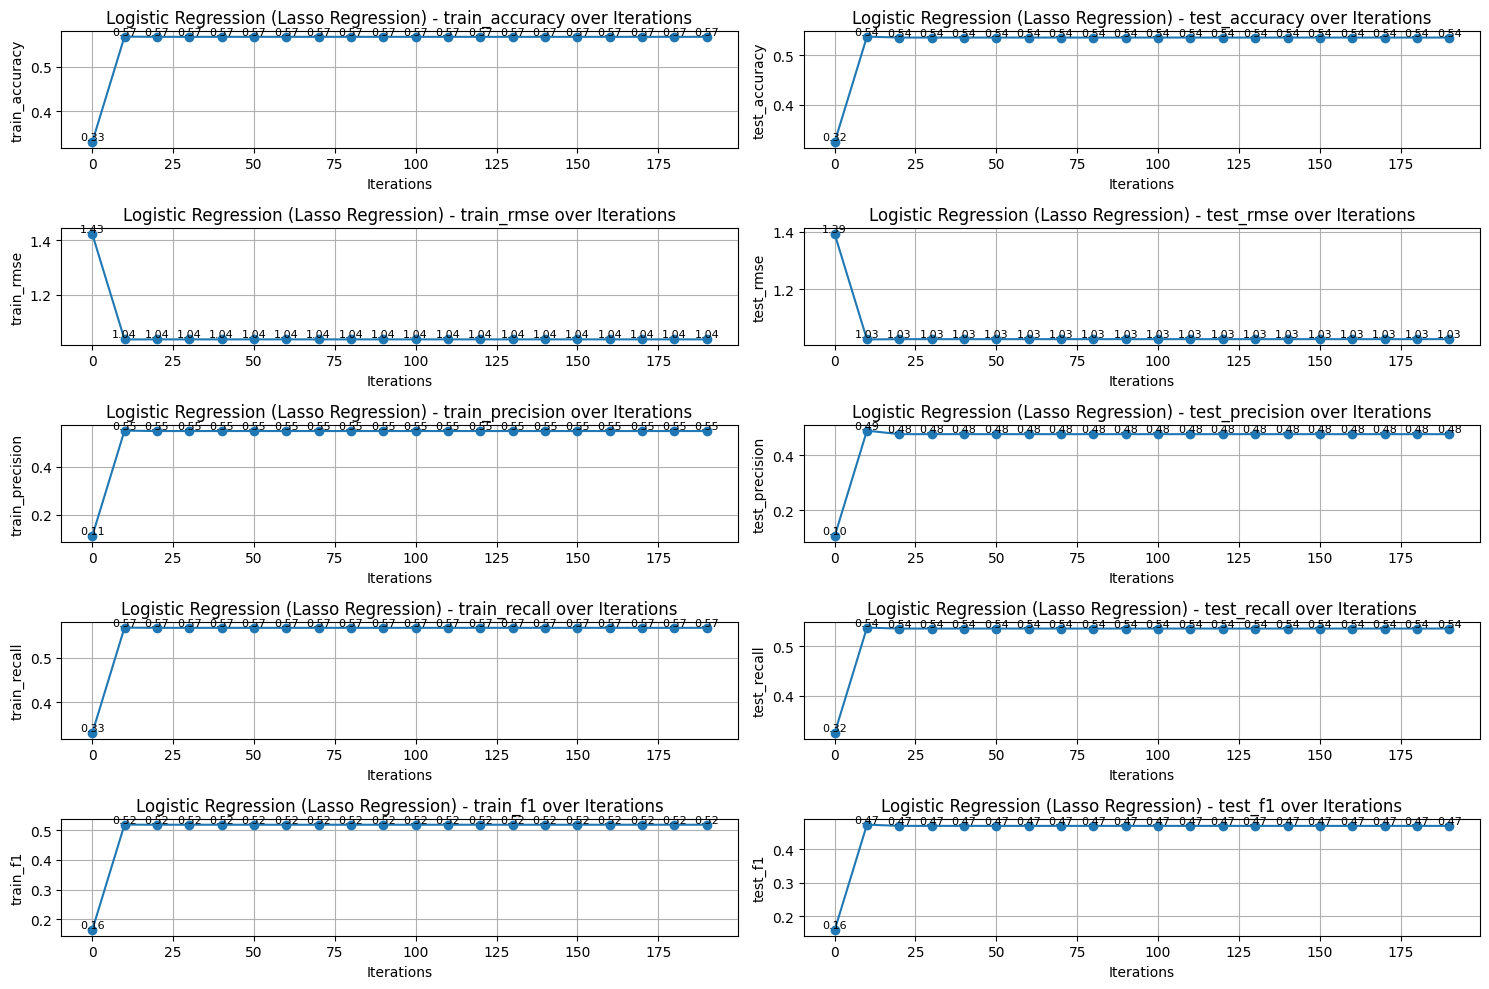

Logistic Regression (Ridge Regression) 




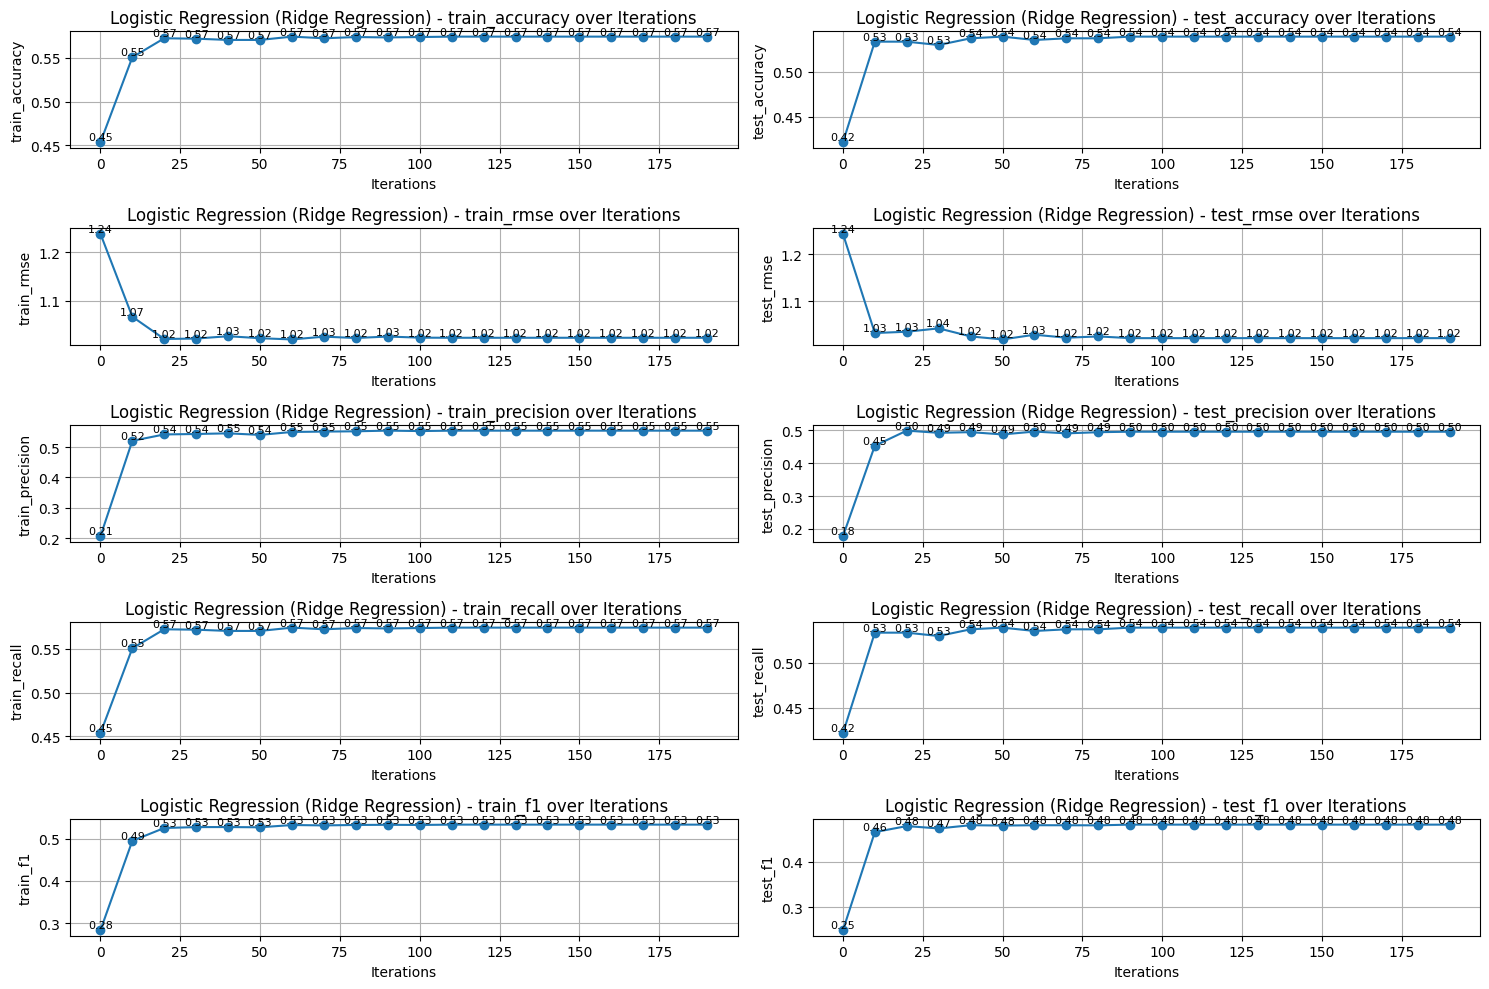

Logistic Regression (Elastic Net) 




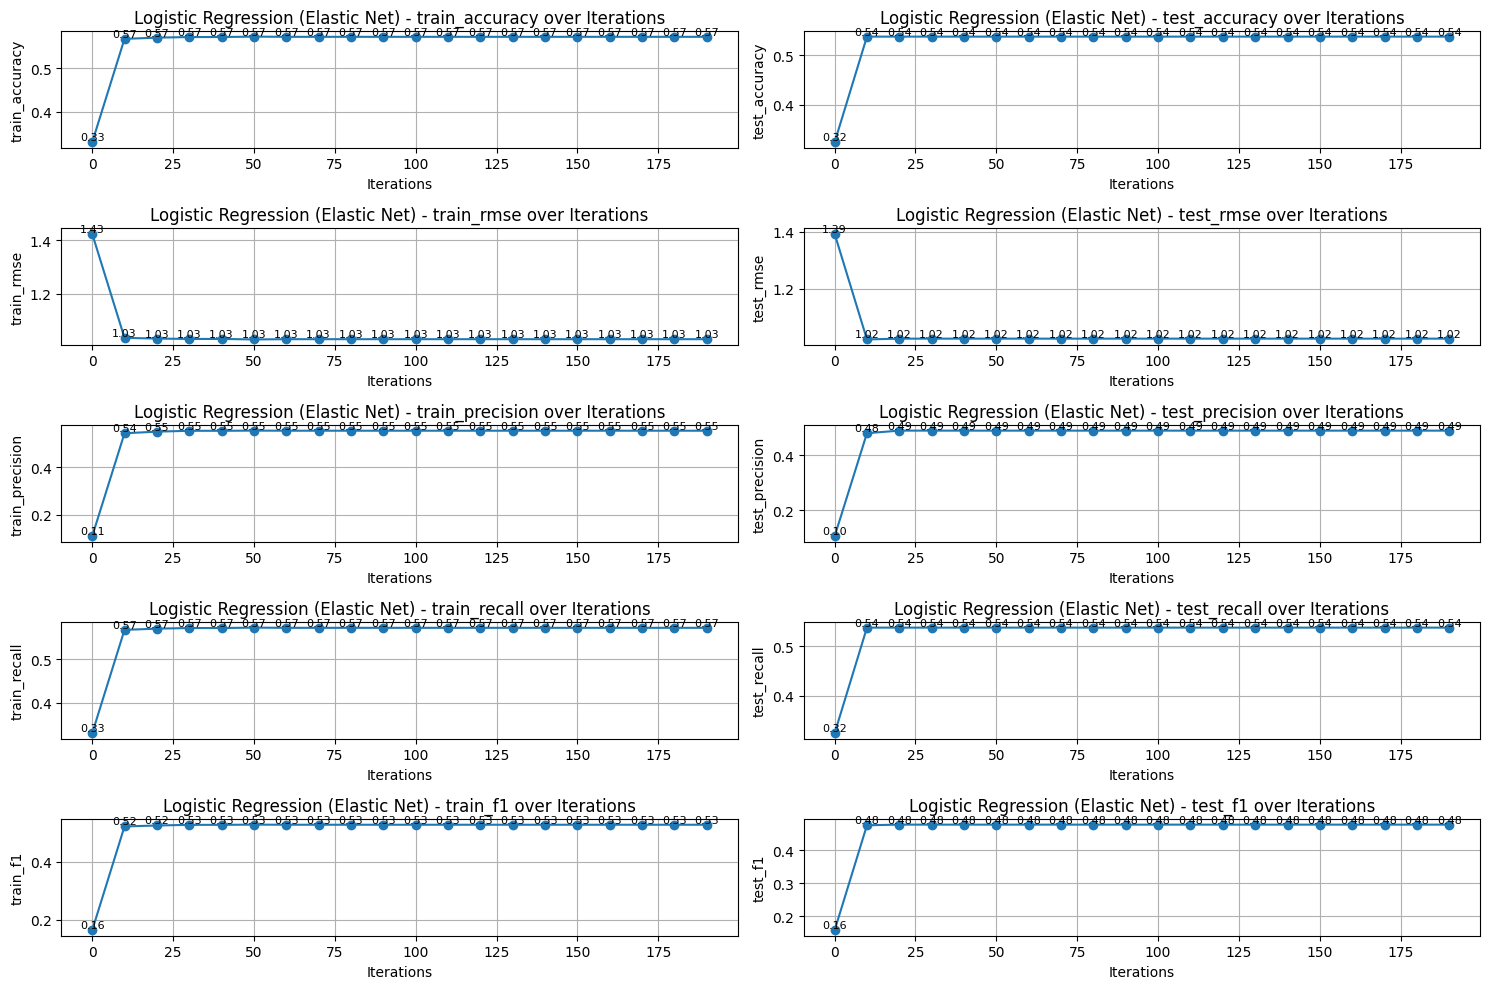

SVM (L1 Regularisation) 




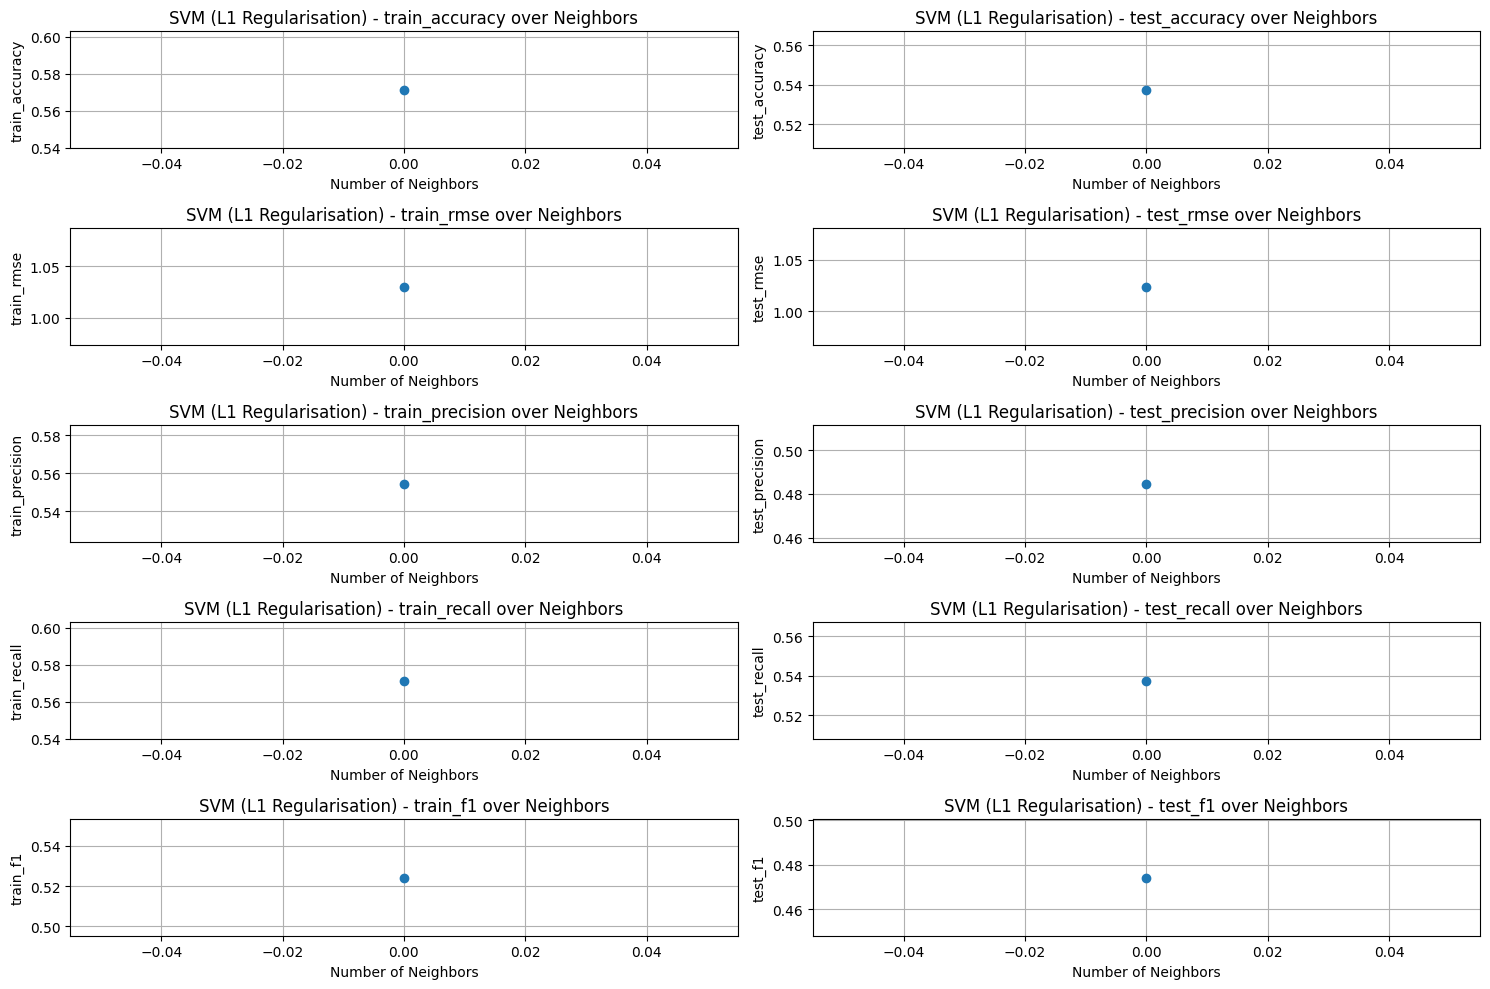

SVM (L2 Regularisation) 




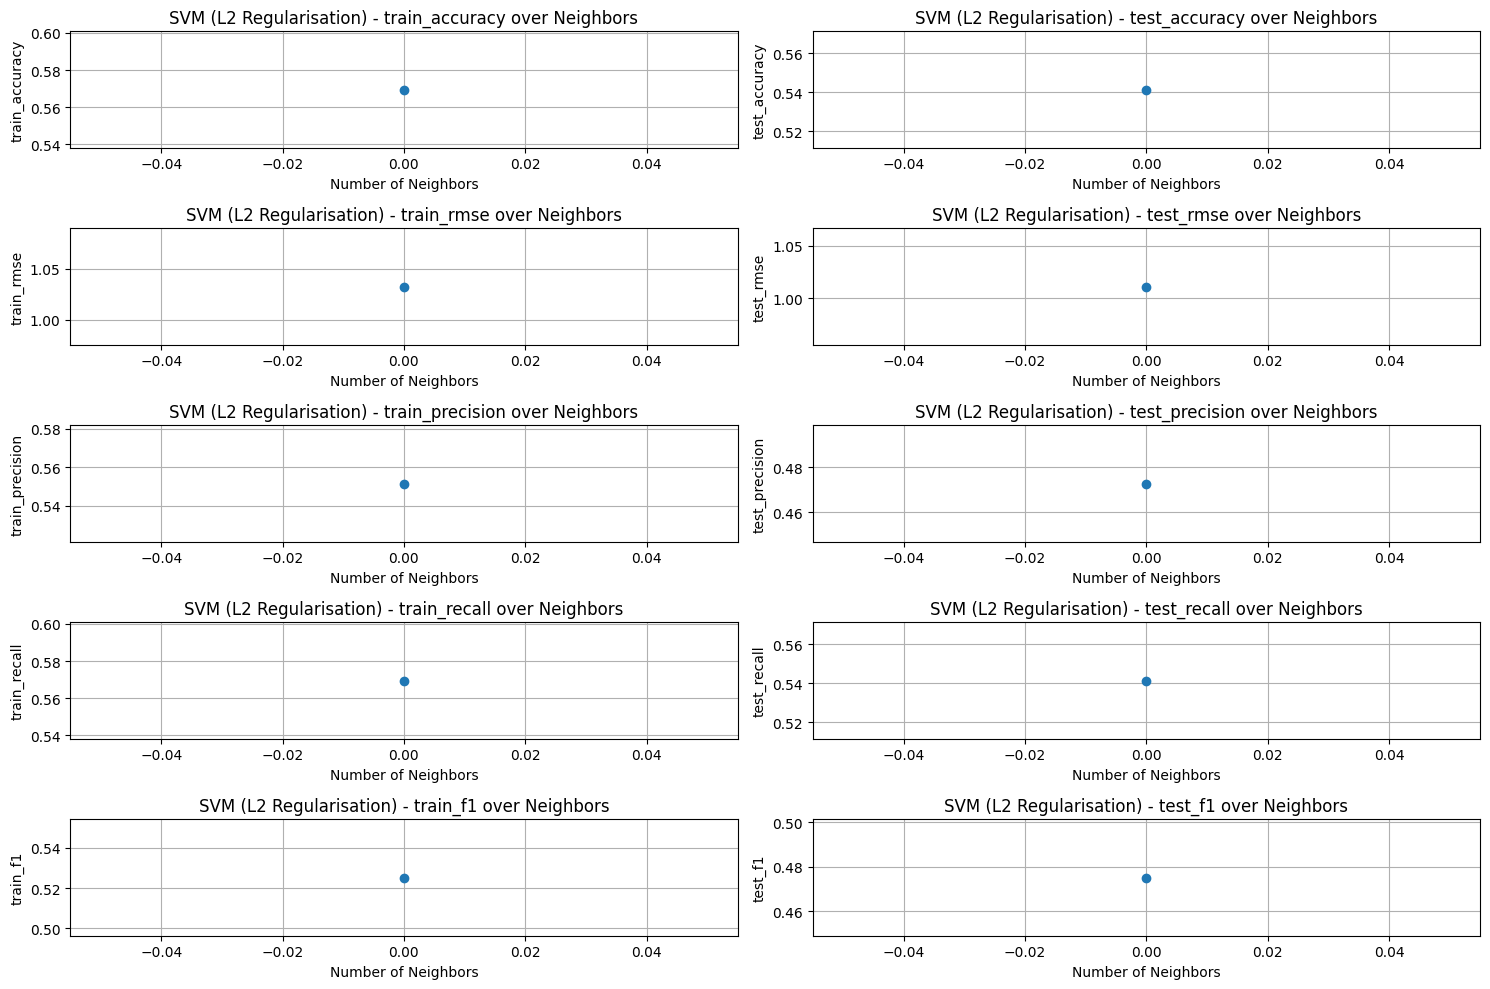

LSTM (Lasso Regression) 




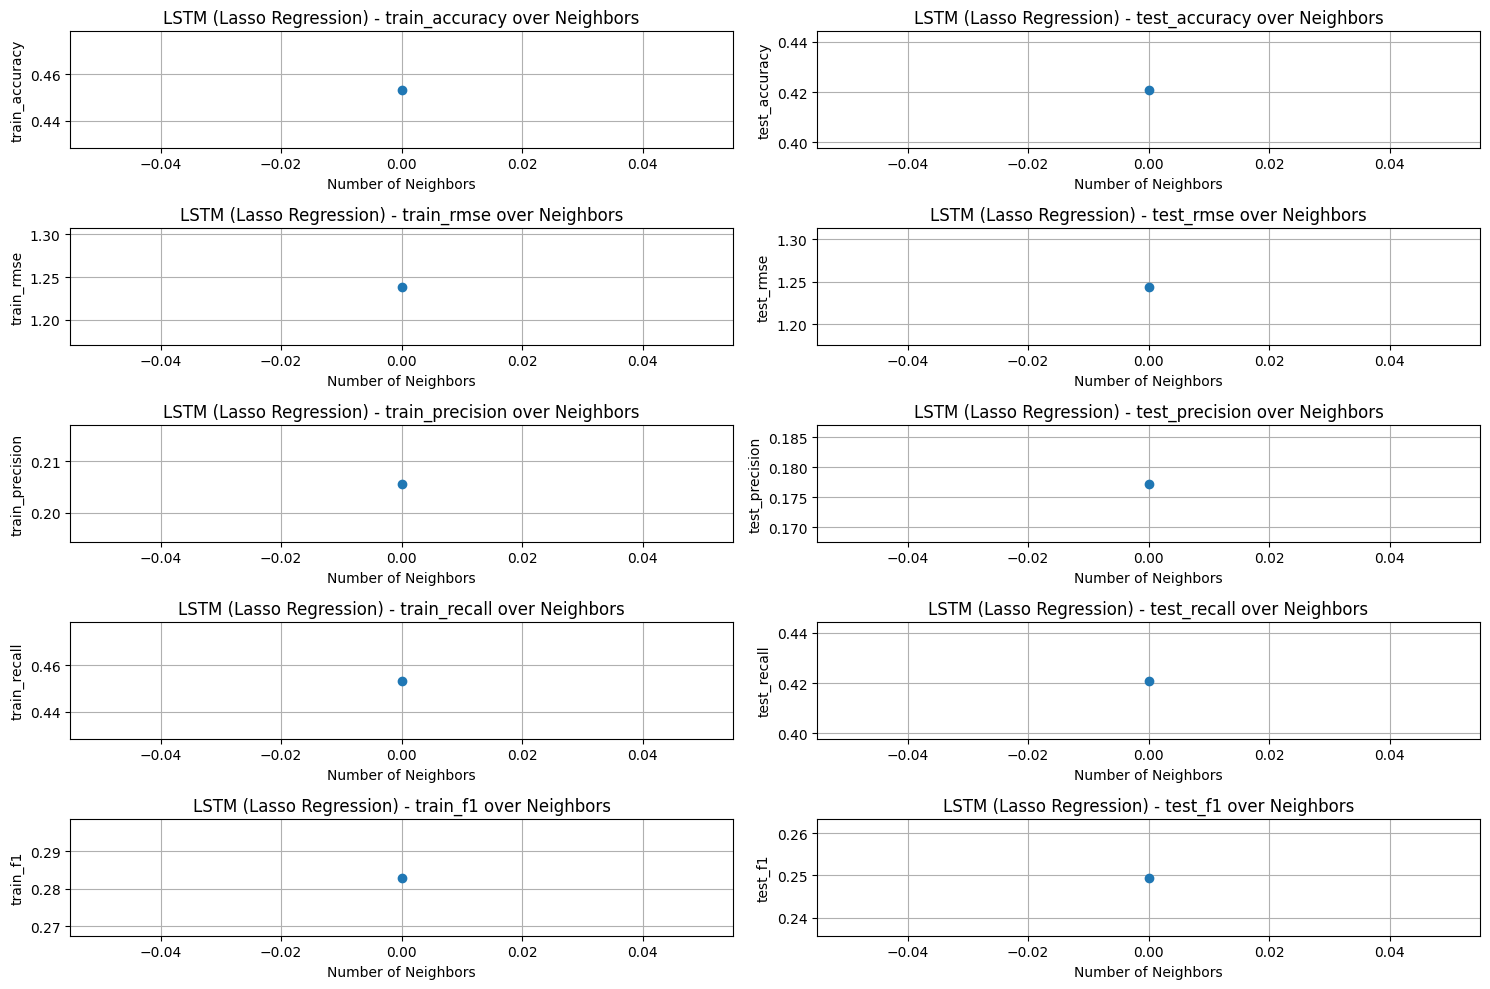

LSTM (Ridge Regression) 




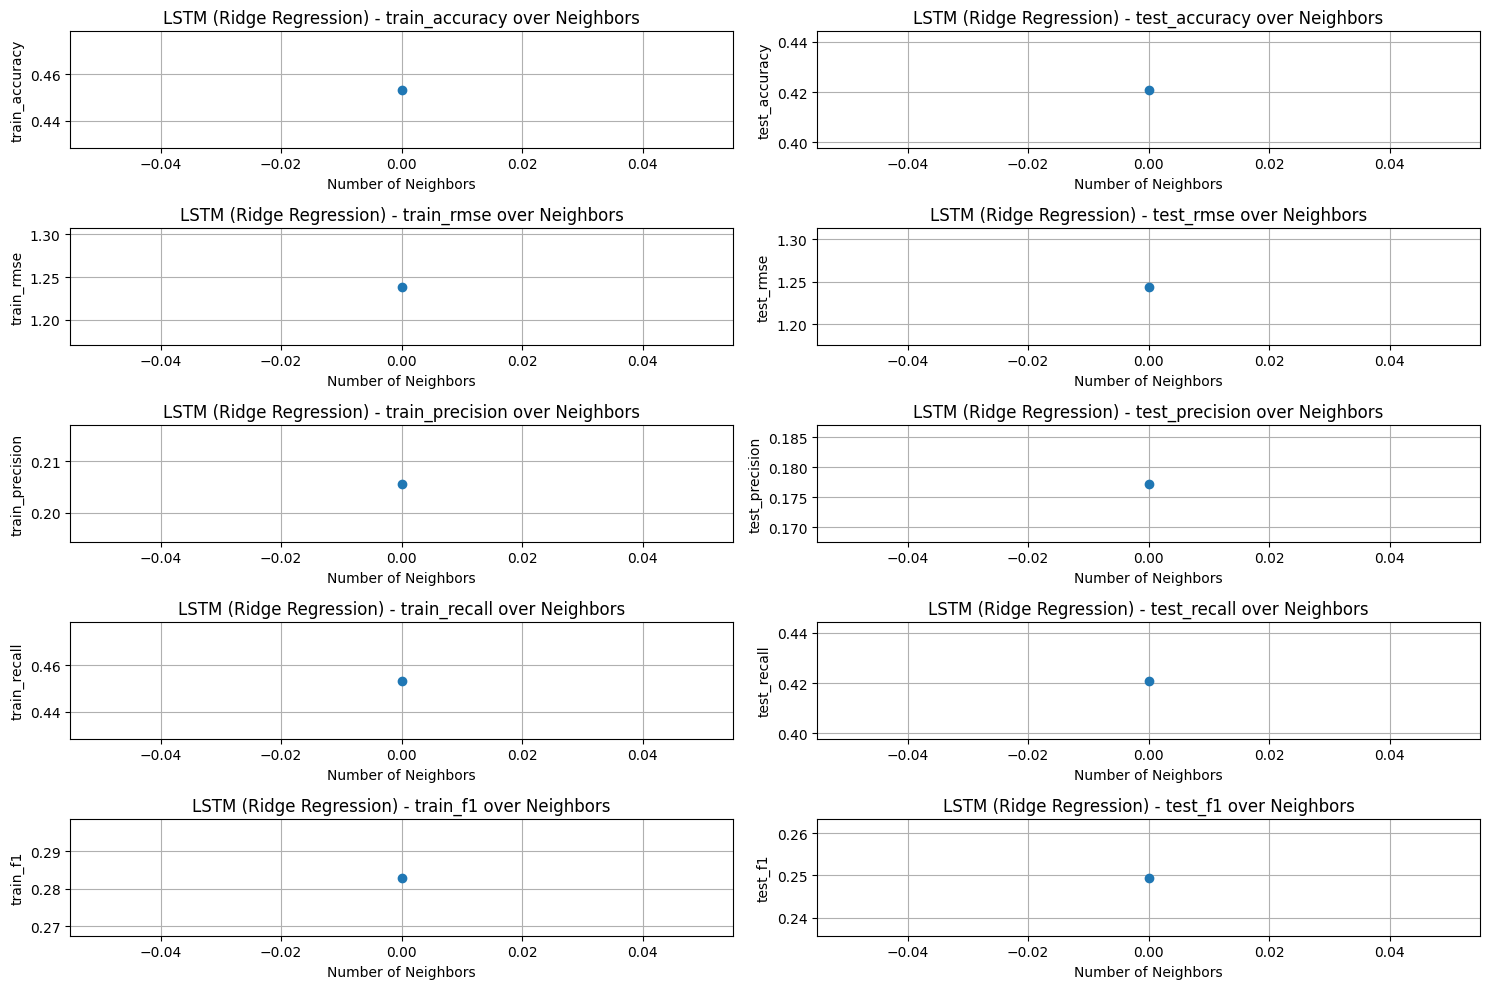

LSTM (Elastic Net) 




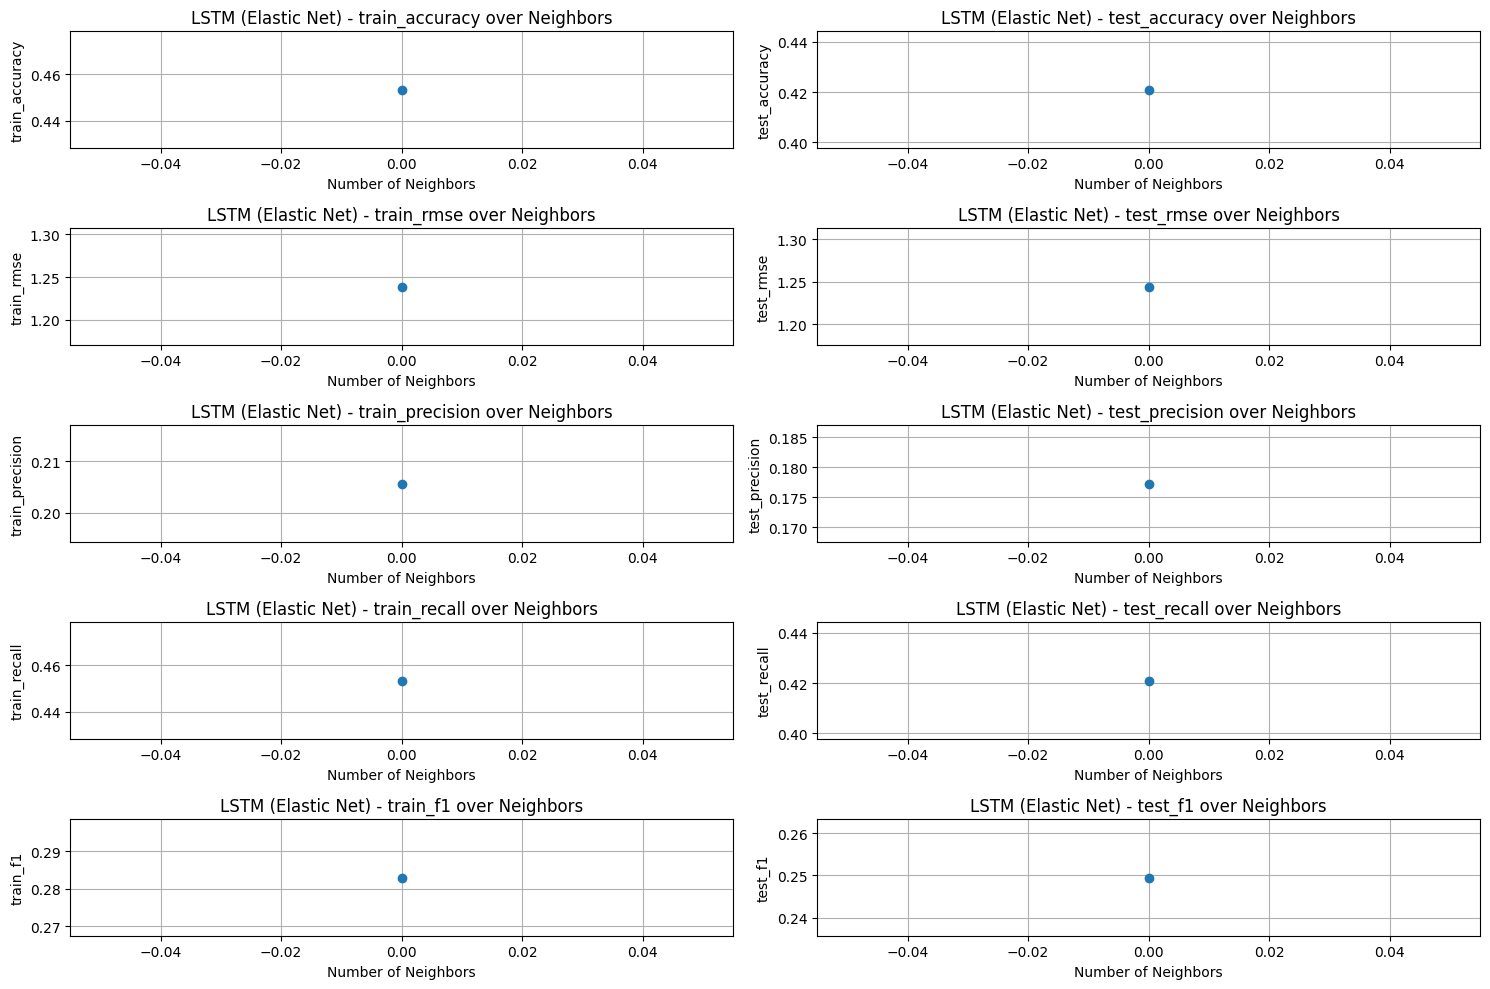

LSTM (Dropout) 




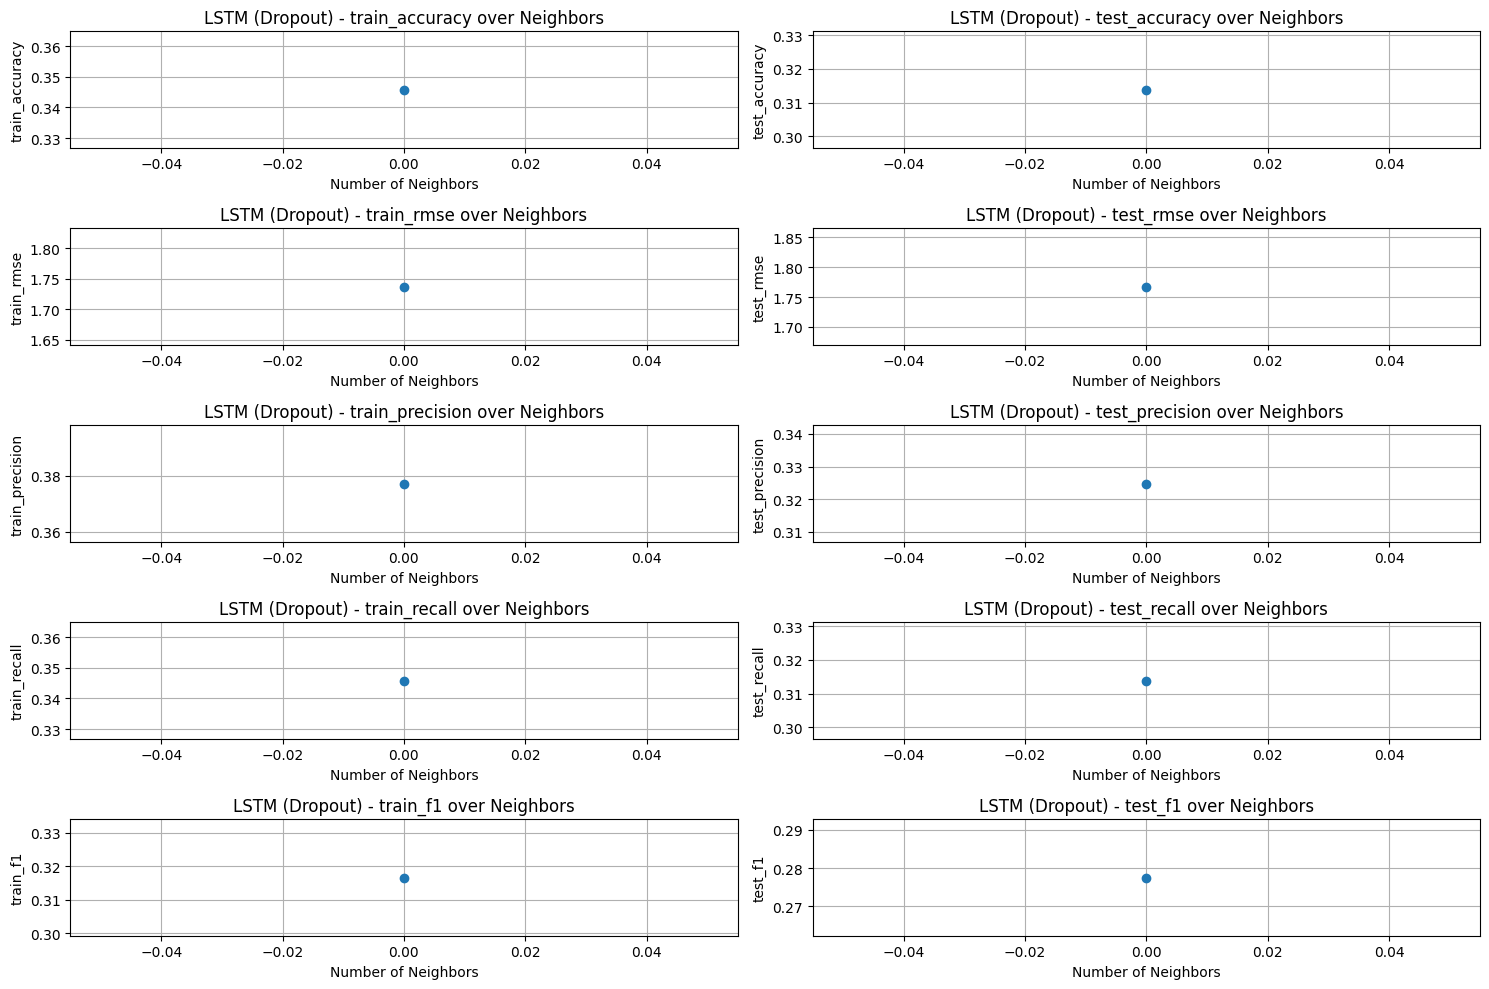

In [783]:
trainer.plot_metrics(metrics_logistic_l1, "Logistic Regression (Lasso Regression)", iterations=iterations)
trainer.plot_metrics(metrics_logistic_l2, "Logistic Regression (Ridge Regression)", iterations=iterations)
trainer.plot_metrics(metrics_logistic_l1_l2, "Logistic Regression (Elastic Net)", iterations=iterations)

trainer.plot_metrics(metrics_svm_l1, "SVM (L1 Regularisation)")
trainer.plot_metrics(metrics_svm_l2, "SVM (L2 Regularisation)")

trainer.plot_metrics(metrics_lstm_l1, "LSTM (Lasso Regression)")
trainer.plot_metrics(metrics_lstm_l2, "LSTM (Ridge Regression)")
trainer.plot_metrics(metrics_lstm_l1_l2, "LSTM (Elastic Net)")
trainer.plot_metrics(metrics_lstm_dropout, "LSTM (Dropout)")

# Gap Rating Model

First, we will narrow down the features that we wish to train our model on. We will include average performances/strengths from the last 5 games – as well as features to build our GAP rating upon.

In [884]:
featuresToKeep = ['Home Team', 'Home Shots on Target', 'Home Corners', 'Away Team', 'Away Shots on Target', 'Away Corners', 'Match Outcome', 'Date', 'Avg Recent Performance Home Last 5 Games', 'Avg Recent Performance Away Last 5 Games']
# featuresToKeep = featuresToKeep + [f for f in list(original_df.columns) if ("5" in f) and ("Goals" not in f)]
gap_df = original_df[featuresToKeep].copy()

with pd.option_context('display.max_rows', 10, 'display.max_columns', None): 
    display(gap_df)

Home Team  Home Shots on Target  Home Corners  \
57           West Ham United                   4.0           4.0   
56              Swansea City                   3.0           5.0   
55                Stoke City                   2.0           5.0   
54               Southampton                   4.0           8.0   
53           Manchester City                   9.0           8.0   
...                      ...                   ...           ...   
2752  Brighton & Hove Albion                   3.0          10.0   
2751               Brentford                   5.0          15.0   
2750                 Arsenal                   5.0           8.0   
2753                 Burnley                   3.0          11.0   
2759        Sheffield United                   1.0          11.0   

              Away Team  Away Shots on Target  Away Corners  Match Outcome  \
57    Tottenham Hotspur                   5.0           3.0             -1   
56              Watford                   4.0           4.0             -1   
55              Chelsea                   4.0           0.0             -1   
54    Manchester United                   4.0           4.0             -1   
53       Crystal Palace                   0.0           2.0              1   
...                 ...                   ...           ...            ...   
2752  Manchester United                   4.0           9.0             -1   
2751   Newcastle United                   7.0          11.0             -1   
2750            Everton                   2.0          11.0              1   
2753  Nottingham Forest                   6.0           5.0             -1   
2759  Tottenham Hotspur                   9.0           9.0             -1   

           Date Avg Recent Performance Home Last 5 Games  \
57   2017-09-23                                      0.3   
56   2017-09-23                                      0.4   
55   2017-09-23                                      0.4   
54   2017-09-23                                      0.6   
53   2017-09-23                                      0.9   
...         ...                                      ...   
2752 2024-05-19                                      0.3   
2751 2024-05-19                                      0.7   
2750 2024-05-19                                      1.0   
2753 2024-05-19                                      0.4   
2759 2024-05-19                                      0.0   

     Avg Recent Performance Away Last 5 Games  
57                                        0.6  
56                                        0.6  
55                                        0.7  
54                                        0.9  
53                                        0.0  
...                                       ...  
2752                                      0.5  
2751                                      0.5  
2750                                      0.9  
2753                                      0.3  
2759                                      0.2  

[2660 rows x 10 columns]

In [885]:
def initialise_gap_ratings(df):    
    """
    Each team receives 4 ratings:
    
    HA GAP - Home Attacking GAP Rating
    HD GAP - Home Defending GAP Rating
    AA GAP - Away Attacking GAP Rating
    AD GAP - Away Defending GAP Rating
    """
    
    initial_value = 0.0  # starting value for all GAP ratings
    gap_columns = ['HA GAP', 'HD GAP', 'AA GAP', 'AD GAP']

    # Create new columns for the GAP ratings
    for col_name in gap_columns:
        df.loc[:, 'Home ' + col_name] = initial_value
        df.loc[:, 'Away ' + col_name] = initial_value
    
    return df

gap_df = initialise_gap_ratings(gap_df)

with pd.option_context('display.max_rows', 10, 'display.max_columns', None): 
    display(gap_df)

Home Team  Home Shots on Target  Home Corners  \
57           West Ham United                   4.0           4.0   
56              Swansea City                   3.0           5.0   
55                Stoke City                   2.0           5.0   
54               Southampton                   4.0           8.0   
53           Manchester City                   9.0           8.0   
...                      ...                   ...           ...   
2752  Brighton & Hove Albion                   3.0          10.0   
2751               Brentford                   5.0          15.0   
2750                 Arsenal                   5.0           8.0   
2753                 Burnley                   3.0          11.0   
2759        Sheffield United                   1.0          11.0   

              Away Team  Away Shots on Target  Away Corners  Match Outcome  \
57    Tottenham Hotspur                   5.0           3.0             -1   
56              Watford                   4.0           4.0             -1   
55              Chelsea                   4.0           0.0             -1   
54    Manchester United                   4.0           4.0             -1   
53       Crystal Palace                   0.0           2.0              1   
...                 ...                   ...           ...            ...   
2752  Manchester United                   4.0           9.0             -1   
2751   Newcastle United                   7.0          11.0             -1   
2750            Everton                   2.0          11.0              1   
2753  Nottingham Forest                   6.0           5.0             -1   
2759  Tottenham Hotspur                   9.0           9.0             -1   

           Date Avg Recent Performance Home Last 5 Games  \
57   2017-09-23                                      0.3   
56   2017-09-23                                      0.4   
55   2017-09-23                                      0.4   
54   2017-09-23                                      0.6   
53   2017-09-23                                      0.9   
...         ...                                      ...   
2752 2024-05-19                                      0.3   
2751 2024-05-19                                      0.7   
2750 2024-05-19                                      1.0   
2753 2024-05-19                                      0.4   
2759 2024-05-19                                      0.0   

     Avg Recent Performance Away Last 5 Games  Home HA GAP  Away HA GAP  \
57                                        0.6          0.0          0.0   
56                                        0.6          0.0          0.0   
55                                        0.7          0.0          0.0   
54                                        0.9          0.0          0.0   
53                                        0.0          0.0          0.0   
...                                       ...          ...          ...   
2752                                      0.5          0.0          0.0   
2751                                      0.5          0.0          0.0   
2750                                      0.9          0.0          0.0   
2753                                      0.3          0.0          0.0   
2759                                      0.2          0.0          0.0   

      Home HD GAP  Away HD GAP  Home AA GAP  Away AA GAP  Home AD GAP  \
57            0.0          0.0          0.0          0.0          0.0   
56            0.0          0.0          0.0          0.0          0.0   
55            0.0          0.0          0.0          0.0          0.0   
54            0.0          0.0          0.0          0.0          0.0   
53            0.0          0.0          0.0          0.0          0.0   
...           ...          ...          ...          ...          ...   
2752          0.0          0.0          0.0          0.0          0.0   
2751          0.0          0.0          0.0          0.0   

In [886]:
def update_gap_ratings(df, λ, φ1, φ2):
    """
    Updates the GAP ratings for a given match row.

    Args:
    - λ: Regularization parameter to control the rate of change. λ > 0.
    - φ1: Weighting parameter between attacking and defending contributions. 0 < φ1 < 1
    - φ2: Weighting parameter between attacking and defending contributions. 0 < φ2 < 1
    """
    
    # create dictionary of teams and GAP ratings
    teams = list(set(df['Home Team']).union(set(df['Away Team'])))
    running_ratings = {}
    
    for team in teams:
        running_ratings[team] = {
            'HA GAP': 0.0,
            'HD GAP': 0.0,
            'AA GAP': 0.0,
            'AD GAP': 0.0
        }
    
    # updates match by match
    for idx, row in df.iterrows():
    
        # extract match data
        Sh = row['Home Shots on Target'] + row['Home Corners']  # Home attacking metric
        Sa = row['Away Shots on Target'] + row['Away Corners']  # Away attacking metric

        home_team = row['Home Team']
        away_team = row['Away Team']
        
       
        # home team GAP ratings
        home_HA = running_ratings[home_team]['HA GAP']
        home_HD = running_ratings[home_team]['HD GAP']
        home_AA = running_ratings[home_team]['AA GAP']
        home_AD = running_ratings[home_team]['AD GAP']

        # away team GAP ratings
        away_HA = running_ratings[away_team]['HA GAP']
        away_HD = running_ratings[away_team]['HD GAP']
        away_AA = running_ratings[away_team]['AA GAP']
        away_AD = running_ratings[away_team]['AD GAP']
        
    
        # update GAP ratings using provided formulas
        new_home_HA = max(home_HA + λ * φ1 * (Sh - ((home_HA + away_AD) / 2)), 0.0)
        new_home_AA = max(home_AA + λ * (1 - φ1) * (Sh - ((home_HA + away_AD) / 2)), 0.0)
        new_home_HD = max(home_HD + λ * φ1 * (Sa - ((away_AA + home_HD) / 2)), 0.0)
        new_home_AD = max(home_AD + λ * (1 - φ1) * (Sa - ((away_AA + home_HD) / 2)), 0.0)
        
        new_away_AA = max(away_AA + λ * φ2 * (Sa - ((away_AA + home_HD) / 2)), 0.0)
        new_away_HA = max(away_HA + λ * (1 - φ2) * (Sa - ((away_AA + home_HD) / 2)), 0.0)
        new_away_AD = max(away_AD + λ * φ2 * (Sh - ((home_HA + away_AD) / 2)), 0.0)
        new_away_HD = max(away_HD + λ * (1 - φ2) * (Sh - ((home_HA + away_AD) / 2)), 0.0)
                          
        # save the new ratings
        df.at[idx, 'Home HA GAP'] = new_home_HA
        df.at[idx, 'Home AA GAP'] = new_home_AA
        df.at[idx, 'Home HD GAP'] = new_home_HD
        df.at[idx, 'Home AD GAP'] = new_home_AD

        df.at[idx, 'Away HA GAP'] = new_away_HA
        df.at[idx, 'Away AA GAP'] = new_away_AA
        df.at[idx, 'Away HD GAP'] = new_away_HD
        df.at[idx, 'Away AD GAP'] = new_away_AD
                          
        running_ratings[home_team]['HA GAP'] = new_home_HA
        running_ratings[home_team]['HD GAP'] = new_home_HD
        running_ratings[home_team]['AA GAP'] = new_home_AA
        running_ratings[home_team]['AD GAP'] = new_home_AD
                          
        running_ratings[away_team]['HA GAP'] = new_away_HA
        running_ratings[away_team]['HD GAP'] = new_away_HD
        running_ratings[away_team]['AA GAP'] = new_away_AA
        running_ratings[away_team]['AD GAP'] = new_away_AD
                          
    return df

gap_df = update_gap_ratings(gap_df, 1, 0.5, 0.5)

The paper says to use a logistic regression model with 3 extra parameters. The model follows the following equation: yˆ=αˆ+β1ˆ(Ha +Hd +Aa +Ad)+β2ˆr. 

However, this model uses betting odds to train the model. The variable r is an average of odds given from selected bookmakers. Since our project does not allow the use of betting odds, we will include the sum of GAP ratings as a specialised feature to be prioritised in training. 

In [887]:
# calculates the mean ignorance score
# y_true is the true class labels, y_prob is the predicted probabilities for the true class

def ignorance_score(y_true, y_prob):    
    
    # Extract the predicted probabilities for the true classes
    prob_true_class = np.array([y_prob[i, y] for i, y in enumerate(y_true)])
    return -np.mean(np.log2(prob_true_class))


# penalty to ensure bounds are maintained.
def penalty(params):
    λ, φ1, φ2 = params
    penalty = 0
    # Apply penalties for violating bounds
    if λ <= 0:  # λ > 0
        penalty += 1e6 * (0 - λ)**2
    if φ1 <= 0 or φ1 >= 1:  # 0 < φ1 < 1
        penalty += 1e6 * min((0 - φ1)**2, (φ1 - 1)**2)
    if φ2 <= 0 or φ2 >= 1:  # 0 < φ2 < 1
        penalty += 1e6 * min((0 - φ2)**2, (φ2 - 1)**2)
    return penalty


In [888]:
# minimises the mean ignorance score
def objective_function(params, df):
    """
    Objective function to minimize (mean ignorance score).
    
    Parameters:
        params: Tuple of (λ, φ1, φ2).
        df: DataFrame containing match data.
    
    Returns:
        Mean ignorance score.
    """
    λ, φ1, φ2 = params
    print(params)
    
    # Update GAP ratings with the current parameters
    updated_df = update_gap_ratings(df.copy(), λ, φ1, φ2)
    
    updated_df = updated_df.drop(['Home Shots on Target', 'Home Corners', 'Away Team', 'Away Shots on Target', 'Away Corners'], axis=1)
    
    
    updated_df = encode_teams(updated_df)
    numerical_features = [col for col in updated_df.columns if ('5' in col) or ('GAP' in col)]
    updated_df = standardize_features(updated_df, numerical_features)
    
    train_df, test_df = chronological_split(updated_df)
    
    X_train, y_train = first_train_df.drop('Match Outcome', axis=1), first_train_df['Match Outcome']
    X_test, y_test = first_test_df.drop('Match Outcome', axis=1), first_test_df['Match Outcome']
    
    # train logistic regression
    # max_iter was chosen as the experimental min num of iterations necessary to converge
    model = LogisticRegression(max_iter=150, solver='lbfgs', random_state=42)
    model.fit(X_train, y_train)
    
    # Predict probabilities
    y_prob = model.predict_proba(X_test)
    
    # Calculate ignorance score
    return ignorance_score(y_test, y_prob)


The paper used a Nelder-Mead method to optimise the parameters. However, it was hard to constrain the parameters using this method, so we opted for a Grid Search over 1000 parameters. 

In [889]:
from itertools import product

# Define ranges for parameters
λ_values = np.linspace(0.01, 10, 5)  # λ > 0
φ1_values = np.linspace(0.0, 1.0, 5)  # 0 < φ1 < 1
φ2_values = np.linspace(0.0, 1.0, 5)  # 0 < φ2 < 1

# Create combinations of parameters
param_combinations = list(product(λ_values, φ1_values, φ2_values))

best_score = float('inf')
best_params = None

# Evaluate all combinations
for λ, φ1, φ2 in param_combinations:
    score = objective_function([λ, φ1, φ2], gap_df)
    if score < best_score:
        best_score = score
        best_params = (λ, φ1, φ2)

print("Best Parameters:", best_params)
print("Best Ignorance Score:", best_score)

[0.01, 0.0, 0.0]
[0.01, 0.0, 0.25]
[0.01, 0.0, 0.5]
[0.01, 0.0, 0.75]
[0.01, 0.0, 1.0]
[0.01, 0.25, 0.0]
[0.01, 0.25, 0.25]
[0.01, 0.25, 0.5]
[0.01, 0.25, 0.75]
[0.01, 0.25, 1.0]
[0.01, 0.5, 0.0]
[0.01, 0.5, 0.25]
[0.01, 0.5, 0.5]
[0.01, 0.5, 0.75]
[0.01, 0.5, 1.0]
[0.01, 0.75, 0.0]
[0.01, 0.75, 0.25]
[0.01, 0.75, 0.5]
[0.01, 0.75, 0.75]
[0.01, 0.75, 1.0]
[0.01, 1.0, 0.0]
[0.01, 1.0, 0.25]
[0.01, 1.0, 0.5]
[0.01, 1.0, 0.75]
[0.01, 1.0, 1.0]
[2.5075, 0.0, 0.0]
[2.5075, 0.0, 0.25]
[2.5075, 0.0, 0.5]
[2.5075, 0.0, 0.75]
[2.5075, 0.0, 1.0]
[2.5075, 0.25, 0.0]
[2.5075, 0.25, 0.25]
[2.5075, 0.25, 0.5]
[2.5075, 0.25, 0.75]
[2.5075, 0.25, 1.0]
[2.5075, 0.5, 0.0]
[2.5075, 0.5, 0.25]
[2.5075, 0.5, 0.5]
[2.5075, 0.5, 0.75]
[2.5075, 0.5, 1.0]
[2.5075, 0.75, 0.0]
[2.5075, 0.75, 0.25]
[2.5075, 0.75, 0.5]
[2.5075, 0.75, 0.75]
[2.5075, 0.75, 1.0]
[2.5075, 1.0, 0.0]
[2.5075, 1.0, 0.25]
[2.5075, 1.0, 0.5]
[2.5075, 1.0, 0.75]
[2.5075, 1.0, 1.0]
[5.005, 0.0, 0.0]
[5.005, 0.0, 0.25]
[5.005, 0.0, 0.5]
[5.00

In [ ]:
with pd.option_context('display.max_rows', 10, 'display.max_columns', None): 
    display(gap_df)

In [ ]:
λ, φ1, φ2 = best_params
gap_df = update_gap_ratings(gap_df, λ, φ1, φ2)

In [ ]:
gap_df = encode_teams(gap_df)
numerical_features = [col for col in gap_df.columns if ('5' in col) or ('GAP' in col)]
gap_df = standardize_features(gap_df, numerical_features)

gap_train_df, gap_test_df = chronological_split(gap_df)

gap_X_train, gap_y_train = gap_train_df.drop('Match Outcome', axis=1), gap_train_df['Match Outcome']
gap_X_test, gap_y_test = gap_test_df.drop('Match Outcome', axis=1), gap_test_df['Match Outcome']

In [ ]:
trainer = RecencyModelTrainingNew()

iterations = np.arange(0, 200, 10)

metrics_gap_rating = trainer.train_with_iterations(gap_X_train, gap_y_train, gap_X_test, gap_y_test, iterations)

In [ ]:
trainer.plot_metrics(metrics_gap_rating, "GAP Rating Logistic Regression", iterations=iterations)